In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib
# import docx
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.utils.class_weight import compute_sample_weight
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition, mark_inset
sns.set_style("whitegrid")

save_folder = './outputs/'

In [3]:
LR_names = ['LogisticRegression'] 
kernels = ['rbf', 'linear'] # These are the best performing ones
SVM_names = ['SVM kernel=%s' %kernel for kernel in kernels] 
activation = ['identity', 'logistic', 'tanh', 'relu']
MLP_names = ['Neural net activation=%s' %act for act in activation]  
RandF_names = ['RandF n=%s' %str(n) for n in [50,100,500]]
NB_names = ['Gaussian NB', 'Gaussian NB, calibrated']

classifiers_names = LR_names + NB_names + SVM_names + MLP_names + RandF_names  

# Make labels short

In [5]:
df_50_norm = pd.read_csv('./Data/df_50_norm.csv', index_col=0)

In [6]:
df_50_norm.index.values

array(['Acinetobacter calcoaceticus', 'Acinetobacter baumannii',
       'Aerococcus viridans', 'Bacillus anthracis', 'Bacillus cereus',
       'Bacillus subtilis', 'Bacteroides fragilis',
       'Bordetella parapertussis', 'Bordetella pertussis',
       'Campylobacter jejuni', 'Chlamydia pneumoniae',
       'Chlamydia trachomatis', 'Citrobacter freundii',
       'Clostridium difficile', 'Clostridium perfringens',
       'Corynebacterium', 'Coxiella burnetii', 'Enterobacter aerogenes',
       'Enterococcus faecalis', 'Enterococcus gallinarum',
       'Francisella philomiragia', 'Francisella tularensis',
       'Helicobacter pylori', 'Klebsiella pneumoniae',
       'Legionella pneumophila', 'Micrococcus luteus',
       'Moraxella catarrhalis', 'Mycobacterium fortuitum',
       'Mycobacterium gordonae', 'Mycobacterium kansasii',
       'Mycoplasma hominis', 'Mycoplasma pneumoniae',
       'Neisseria gonorrhoeae', 'Neisseria meningitidis',
       'Oligella urethralis', 'Pasteurella multoci

In [8]:
short_labels=[]
for name in df_50_norm.index.values:
    if(len(name.split())>1):
        short_labels.append(name.split()[0][0]+'. '+name.split()[1])
    else:
        short_labels.append(name)

In [9]:
short_labels

['A. calcoaceticus',
 'A. baumannii',
 'A. viridans',
 'B. anthracis',
 'B. cereus',
 'B. subtilis',
 'B. fragilis',
 'B. parapertussis',
 'B. pertussis',
 'C. jejuni',
 'C. pneumoniae',
 'C. trachomatis',
 'C. freundii',
 'C. difficile',
 'C. perfringens',
 'Corynebacterium',
 'C. burnetii',
 'E. aerogenes',
 'E. faecalis',
 'E. gallinarum',
 'F. philomiragia',
 'F. tularensis',
 'H. pylori',
 'K. pneumoniae',
 'L. pneumophila',
 'M. luteus',
 'M. catarrhalis',
 'M. fortuitum',
 'M. gordonae',
 'M. kansasii',
 'M. hominis',
 'M. pneumoniae',
 'N. gonorrhoeae',
 'N. meningitidis',
 'O. urethralis',
 'P. multocida',
 'P. acnes',
 'P. mirabilis',
 'P. vulgaris',
 'P. aeruginosa',
 'S. enterica',
 'S. marcescens',
 'S. epidermidis',
 'S. lugdunensis',
 'S. saprophyticus',
 'S. pyogenes',
 'T. pallidum',
 'Y. enterocolitica',
 'Y. pestis',
 'Y. pseudotuberculosis']

# Helper Functions

In [10]:
def to_word(df, index):
    # open an existing document
    doc = docx.Document('tables.docx')

    # add a table to the end and create a reference variable
    # extra row is so we can add the header row
    t = doc.add_table(df.shape[0]+1, df.shape[1]+1)

    # add the header rows.
    for j in range(df.shape[-1]):
        t.cell(0,j+1).text = df.columns[j]
        
    if index == True:    
        # add the index rows.
        for j in range(df.shape[0]):
            t.cell(j+1,0).text = df.index[j]

    # add the rest of the data frame
    for i in range(df.shape[0]):
        for j in range(df.shape[-1]):
            t.cell(i+1,j+1).text = str(df.values[i,j])

    # save the doc
    doc.save('tables.docx')
    
# Used to find nearest threshold
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
#     print('nearest difference:', min(np.abs(array - value))) # to make sure differences aren't too big
#     print(array[idx])
    return idx

# 1) 10x LOO Results

# Table 1

In [50]:
results = pd.read_csv('./outputs/'+'results.csv', index_col=0)

In [1149]:
df_summary=pd.DataFrame(columns = results.columns)
for i,method in enumerate(classifiers_names):
    df_summary=df_summary.append(round(results[(results['method']==method) & (results['short']==0)].mean(),3),ignore_index=True)
df_summary = df_summary.drop(['species', 'method','short','roc_auc3','roc_auc4','predict_time'], axis=1)
df_summary.index = classifiers_names
df_summary.columns = ['Model fit time (s)', 'Classification Accuracy', 'Probability ROC AUC', 'Entropy ROC AUC']
df_summary.to_csv(save_folder+'results_summary0.csv')
# to_word(df_summary)
df_summary

,Model fit time (s),Classification Accuracy,Probability ROC AUC,Entropy ROC AUC
LogisticRegression,21.547,0.995,0.902,0.902
Gaussian NB,0.167,0.977,0.579,0.758
"Gaussian NB, calibrated",1.326,0.977,0.569,0.539
SVM kernel=rbf,125.677,0.996,0.928,0.928
SVM kernel=linear,29.336,0.995,0.940,0.941
Neural net activation=identity,22.199,0.992,0.882,0.883
Neural net activation=logistic,23.347,0.996,0.964,0.965
Neural net activation=tanh,17.767,0.996,0.953,0.954
Neural net activation=relu,14.745,0.995,0.936,0.937
RandF n=50,0.800,0.995,0.987,0.988


In [1165]:
for j in range(2):
    df_summary=pd.DataFrame(columns = results.columns)
    for i,method in enumerate(classifiers_names):
        df_summary=df_summary.append(round(results[(results['method']==method) & (results['short']==j)].mean(),3),ignore_index=True)
    df_summary = df_summary.drop(['species', 'method','short','roc_auc3','roc_auc4','predict_time','roc_auc prob','roc_auc entropy'], axis=1)
    df_summary.index = classifiers_names
    if (j==0):
        df_summ = df_summary
    else:
        df_summ = pd.concat((df_summ,df_summary), axis=1)  
df_summ.columns = ['Model fit time (s)', 'Classification Accuracy', 'Model fit time (s)', 'Classification Accuracy']
df_summ = df_summ.drop(['Gaussian NB, calibrated','RandF n=50'])
# df_summ.index = classifiers_names_article
df_summ.index = classifiers_names
df_summ = df_summ.round({'Model fit time (s)':2})
# df_summary.to_csv(save_folder+'results_summary0.csv')
to_word(df_summ, index=True)
df_summ

,Model fit time (s),Classification Accuracy,Model fit time (s),Classification Accuracy
Logistic Regression,21.55,0.995,13.18,0.995
Gaussian NB,0.17,0.977,0.07,0.974
SVM (rbf),125.68,0.996,31.34,0.996
SVM (linear),29.34,0.995,6.75,0.995
Neural net (identity),22.20,0.992,25.24,0.992
Neural net (logistic),23.35,0.996,25.17,0.997
Neural net (tanh),17.77,0.996,19.99,0.997
Neural net (relu),14.74,0.995,14.83,0.997
RandF n=100,1.29,0.995,0.89,0.995
RandF n=500,5.30,0.996,3.53,0.996


# Pick method to investigate in Figures below

In [65]:
fig_method = 'RandF n=500' #'SVM kernel=rbf'

# Figure 1

In [76]:
save_folder = './outputs/'

In [77]:
fig1 = pd.read_pickle(save_folder+'fig_save.pkl')
fig1select = fig1[(fig1['method']==fig_method) & (fig1['species']=='C. koseri') & (fig1['novelty_method']=='prob_all') & (fig1['short']==0)]
fig1b = pd.read_pickle(save_folder+'roc_curves.pkl')
fig1bselect = fig1b[(fig1b['method']==fig_method) & (fig1b['species']=='C. koseri') & (fig1b['novelty_method']=='prob_all') & (fig1b['short']==0)]

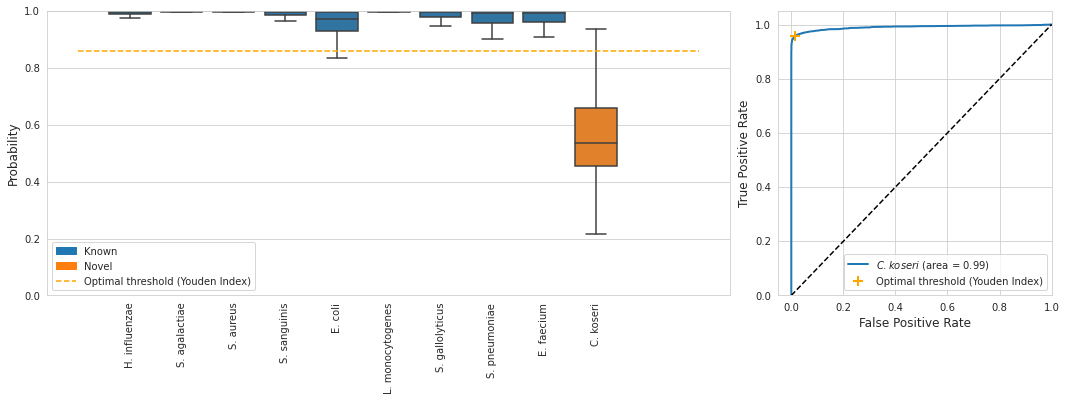

In [80]:
sns.set_style("whitegrid")

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6.96/1.33), gridspec_kw={'width_ratios': [2.5, 1]})

clrs = ['C0' if (x < 9) else 'C1' for x in range(10)]
sns.boxplot(x=fig1select['index'].values[0], y=fig1select['score'].values[0], dodge=False, showfliers=False, palette=clrs, ax=ax1)

# Make ax1 look good
ax1.set_ylim(0, 1)
ax1.set_ylabel('Probability', fontsize=12)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation='vertical')

# Plot ROC curve from accumulated experiments 
fpr = fig1bselect['fpr'].values[0]
tpr = fig1bselect['tpr'].values[0]
roc_auc = fig1bselect['auc'].values[0]
ax2.plot(fpr, tpr, label='$\it{C. koseri}$ (area = %0.2f)' %(roc_auc), color='C0', linewidth=2)

# Calculate youden
youden_index = tpr - fpr 
fpr_thresh = fpr[np.argmax(youden_index)]
tpr_thresh = tpr[np.argmax(youden_index)]

# Plot threshold markers
ax2.plot(fpr_thresh, tpr_thresh, '+', mew=2, ms=10, label='Optimal threshold (Youden Index)', color='orange')

ax2.plot([0, 1], [0, 1], color='black', linestyle='--')
ax2.set_xlim([-0.05, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate', fontsize=12)
ax2.set_ylabel('True Positive Rate', fontsize=12)
ax2.legend()

# Plot horizontal threshold lines
ax1.hlines(y=fig1select['threshold'].values[0], xmin=-1, xmax=11, color='orange', linestyle='dashed', label='Optimal Threshold (Youden Index)')

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.1)

# Make legend look good
blue_patch = mpatches.Patch(color='C0', label='Known')
orange_patch = mpatches.Patch(color='C1', label='Novel')
orange_line = mlines.Line2D([], [], color='orange', linestyle='--', label='Optimal threshold (Youden Index)')
ax1.legend(handles=[blue_patch,orange_patch, orange_line])

plt.savefig('../../reports/figures/Figure3.svg', bbox_inches='tight')
plt.show()

# Alternative Threshold Finding

In [910]:
fig1select['score'].values[0].groupby(fig1select['score'].values[0].index).describe()


np.percentile

,count,mean,std,min,25%,50%,75%,max
C. koseri,2052.0,0.645824,0.147377,0.24,0.520,0.65,0.76,0.96
E. coli,171.0,0.900292,0.114576,0.41,0.875,0.93,0.98,1.00
E. faecium,217.0,0.925530,0.140932,0.30,0.940,0.98,1.00,1.00
H. influenzae,448.0,0.968571,0.074834,0.36,0.970,0.99,1.00,1.00
L. monocytogenes,444.0,0.985563,0.039824,0.60,0.990,1.00,1.00,1.00
S. agalactiae,428.0,0.987220,0.032499,0.63,0.990,1.00,1.00,1.00
S. aureus,422.0,0.981564,0.069494,0.31,0.990,1.00,1.00,1.00
S. gallolyticus,417.0,0.958801,0.073393,0.44,0.950,0.99,1.00,1.00
S. pneumoniae,251.0,0.949522,0.090936,0.47,0.945,0.99,1.00,1.00
S. sanguinis,448.0,0.958996,0.079653,0.36,0.960,0.99,1.00,1.00


# Figure 2

### Calculations for overall threshold and figure 2a

In [136]:
fig2ov = pd.read_pickle(save_folder+'accumulate.pkl')
fig2ovselect = fig2ov[(fig2ov['method']==fig_method) & (fig2ov['novelty_method']=='prob_all') & (fig2ov['short']==0)]
fig2ovselect

,species,method,short,novelty_method,Known,Probability,weights
40,S. agalactiae,RandF n=100,0,prob_all,"[True, True, True, True, True, True, True, Tru...","[0.94, 0.9, 0.99, 1.0, 1.0, 0.98, 0.99, 0.97, ...","[0.8506392266916121, 0.8506392266916121, 0.850..."
88,S. gallolyticus,RandF n=100,0,prob_all,"[True, True, True, True, True, True, True, Tru...","[0.99, 1.0, 0.99, 0.97, 0.99, 0.97, 1.0, 0.76,...","[0.8081413210445468, 0.8081413210445468, 0.808..."
136,C. koseri,RandF n=100,0,prob_all,"[True, True, True, True, True, True, True, Tru...","[0.99, 1.0, 0.89, 1.0, 0.99, 1.0, 1.0, 0.5, 1....","[0.8160813308687616, 0.8160813308687616, 0.816..."
184,L. monocytogenes,RandF n=100,0,prob_all,"[True, True, True, True, True, True, True, Tru...","[0.99, 0.99, 0.97, 0.67, 0.99, 0.95, 0.97, 0.9...","[0.8497506234413965, 0.8497506234413965, 0.849..."
232,H. influenzae,RandF n=100,0,prob_all,"[True, True, True, True, True, True, True, Tru...","[1.0, 1.0, 1.0, 0.9, 0.95, 1.0, 1.0, 0.98, 1.0...","[0.8534644194756554, 0.8534644194756554, 0.853..."
280,S. sanguinis,RandF n=100,0,prob_all,"[True, True, True, True, True, True, True, Tru...","[0.99, 1.0, 0.91, 0.88, 1.0, 1.0, 1.0, 1.0, 0....","[0.8423507462686567, 0.8423507462686567, 0.842..."
328,S. aureus,RandF n=100,0,prob_all,"[True, True, True, True, True, True, True, Tru...","[1.0, 1.0, 0.98, 0.99, 0.92, 1.0, 1.0, 0.99, 1...","[0.8119040295293756, 0.8119040295293756, 0.811..."
376,S. pneumoniae,RandF n=100,0,prob_all,"[True, True, True, True, True, True, True, Tru...","[1.0, 1.0, 0.54, 0.95, 0.98, 0.78, 0.98, 0.99,...","[0.6842337052260716, 0.6842337052260716, 0.684..."
424,E. faecium,RandF n=100,0,prob_all,"[True, True, True, True, True, True, True, Tru...","[0.88, 0.57, 1.0, 1.0, 0.84, 0.99, 0.93, 0.99,...","[0.6657917760279966, 0.6657917760279966, 0.665..."
472,E. coli,RandF n=100,0,prob_all,"[True, True, True, True, True, True, True, Tru...","[0.98, 0.89, 1.0, 1.0, 0.99, 1.0, 0.99, 0.99, ...","[0.6208428899082569, 0.6208428899082569, 0.620..."


In [82]:
def accumulated_ROC(fig2ovselect, plot=False):
    y_true = np.concatenate(fig2ovselect['Known'].values)
    y_scores = np.concatenate(fig2ovselect['Probability'].values)
    y_weights = np.concatenate(fig2ovselect['weights'].values)

    fpr, tpr, thresholds = roc_curve(y_true, y_scores)  
    roc_auc_all = auc(fpr, tpr)
    youden_index = tpr - fpr 
    acc_thresh = thresholds[np.argmax(youden_index)]
    fpr_thresh = fpr[np.argmax(youden_index)]
    tpr_thresh = tpr[np.argmax(youden_index)]
    print(roc_auc_all, acc_thresh)

    if(plot):
        plt.plot(fpr, tpr, label='Accumulated LOO experiments (area = %0.2f)' %(roc_auc_all))
        plt.plot(fpr_thresh, tpr_thresh, '+', mew=2, ms=20, label='Optimal threshold')

#     # weight so there's an overall balance between 0's and 1's
#     y_weights_all = compute_sample_weight(class_weight='balanced', y=y_true)
#     fpr, tpr, thresholds = roc_curve(y_true, y_scores, sample_weight=y_weights_all)  
#     roc_auc_all = auc(fpr, tpr)
#     youden_index = tpr - fpr 
#     acc_thresh = thresholds[np.argmax(youden_index)]
#     fpr_thresh = fpr[np.argmax(youden_index)]
#     tpr_thresh = tpr[np.argmax(youden_index)]
#     print(roc_auc_all, acc_thresh)
#     plt.plot(fpr, tpr, label='Accumulated LOO experiments2 (area = %0.2f)' %(roc_auc_all))
#     plt.plot(fpr_thresh, tpr_thresh, '+', mew=2, ms=20, label='Optimal threshold2')

    # # weight so there's a balance for each experiment
    # fpr, tpr, thresholds = roc_curve(y_true, y_scores, sample_weight=y_weights)  
    # roc_auc_all = auc(fpr, tpr)
    # print(roc_auc_all)
    # youden_index = tpr - fpr 
    # acc_thresh = thresholds[np.argmax(youden_index)]
    # fpr_thresh = fpr[np.argmax(youden_index)]
    # tpr_thresh = tpr[np.argmax(youden_index)]
    # plt.plot(fpr, tpr, label='Accumulated LOO experiments3 (area = %0.2f)' %(roc_auc_all))
    # plt.plot(fpr_thresh, tpr_thresh, '+', mew=2, ms=20, label='Optimal threshold3')

    # # weight by leave one out class size
    # test_set_size = [len(fig2ovselect[fig2ovselect['species']==label]['Known'].values[0]) for label in fig2ovselect['species'].values]
    # balance_classes = np.hstack([np.ones(test_set_size[i])*dfs10weights['Weight'][i] for i in range(10)])
    # fpr, tpr, thresholds = roc_curve(y_true, y_scores, sample_weight=y_weights)  
    # roc_auc_all = auc(fpr, tpr)
    # youden_index = tpr - fpr 
    # acc_thresh = thresholds[np.argmax(youden_index)]
    # fpr_thresh = fpr[np.argmax(youden_index)]
    # tpr_thresh = tpr[np.argmax(youden_index)]
    # print(roc_auc_all, acc_thresh)

    # plt.plot(fpr, tpr, label='Accumulated LOO experiments3 (area = %0.2f)' %(roc_auc_all))
    # plt.plot(fpr_thresh, tpr_thresh, '+', mew=2, ms=20, label='Optimal threshold3')

    if(plot):
        plt.plot([0, 1], [0, 1], color='black', linestyle='--')
        plt.xlim([-0.05, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate', fontsize=12)
        plt.ylabel('True Positive Rate', fontsize=12)
        plt.legend(loc='lower right')
        plt.show()
    
    return acc_thresh
    
acc_thresh = accumulated_ROC(fig2ovselect)

0.9887260545229873 0.86


### Figure 2b

In [145]:
fig2 = pd.read_pickle(save_folder+'roc_curves.pkl')
fig2select = fig2[(fig2['method']==fig_method) & (fig2['novelty_method']=='prob_all') & (fig2['short']==0)]
fig2select

,species,method,short,novelty_method,fpr,tpr,thresholds,auc,threshold
40,S. agalactiae,RandF n=100,0,prob_all,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.4368568755846586, 0.5859058309946991, ...","[2.0, 1.0, 0.99, 0.98, 0.97, 0.96, 0.95, 0.94,...",0.998989,0.50
88,S. gallolyticus,RandF n=100,0,prob_all,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.47096774193548385, 0.6264208909370199,...","[2.0, 1.0, 0.99, 0.98, 0.97, 0.96, 0.95, 0.94,...",0.997683,0.67
136,C. koseri,RandF n=100,0,prob_all,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.000487329434697855...","[0.0, 0.4882932840418977, 0.6386321626617375, ...","[2.0, 1.0, 0.99, 0.98, 0.97, 0.96, 0.95, 0.94,...",0.973765,0.89
184,L. monocytogenes,RandF n=100,0,prob_all,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0026737967914...","[0.0, 0.4544887780548628, 0.6103491271820449, ...","[2.0, 1.0, 0.99, 0.98, 0.97, 0.96, 0.95, 0.94,...",0.955709,0.90
232,H. influenzae,RandF n=100,0,prob_all,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.47191011235955055, 0.6164169787765293,...","[2.0, 1.0, 0.99, 0.98, 0.97, 0.96, 0.95, 0.94,...",0.999502,0.52
280,S. sanguinis,RandF n=100,0,prob_all,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.4993781094527363, 0.6433457711442786, ...","[2.0, 1.0, 0.99, 0.98, 0.97, 0.96, 0.95, 0.94,...",0.996372,0.60
328,S. aureus,RandF n=100,0,prob_all,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.44878498923408183, 0.597662257766841, ...","[2.0, 1.0, 0.99, 0.98, 0.97, 0.96, 0.95, 0.94,...",0.987296,0.76
376,S. pneumoniae,RandF n=100,0,prob_all,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.4903112155020552, 0.6303581914268938, ...","[2.0, 1.0, 0.99, 0.98, 0.97, 0.96, 0.95, 0.94,...",0.992146,0.77
424,E. faecium,RandF n=100,0,prob_all,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.4864391951006124, 0.6439195100612424, ...","[2.0, 1.0, 0.99, 0.98, 0.97, 0.96, 0.95, 0.94,...",0.997895,0.70
472,E. coli,RandF n=100,0,prob_all,"[0.0, 0.0, 0.0, 0.0, 0.0011862396204033216, 0....","[0.0, 0.5151949541284404, 0.6803325688073395, ...","[2.0, 1.0, 0.99, 0.98, 0.97, 0.96, 0.95, 0.94,...",0.986811,0.88


In [146]:
dfs10weights = pd.read_csv('dfs10weights.csv', index_col=0)
dfs10weights

,Nr. Curves,Weight
S. agalactiae,2249,0.812850
S. gallolyticus,2006,0.911316
C. koseri,2052,0.890887
L. monocytogenes,2244,0.814661
H. influenzae,2265,0.807108
S. sanguinis,2202,0.830200
S. aureus,2028,0.901430
S. pneumoniae,1255,1.456653
E. faecium,1137,1.607828
E. coli,843,2.168565


/tmp/ipykernel_36346/1389180293.py:21: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "y+" (-> color='y'). The keyword argument will take precedence.
  plt.plot(fpr[idx], tpr[idx], 'y+', mew=2, ms=10, label='Overall threshold' if i==9 else '', color='grey')
/tmp/ipykernel_36346/1389180293.py:21: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "y+" (-> color='y'). The keyword argument will take precedence.
  plt.plot(fpr[idx], tpr[idx], 'y+', mew=2, ms=10, label='Overall threshold' if i==9 else '', color='grey')
/tmp/ipykernel_36346/1389180293.py:21: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "y+" (-> color='y'). The keyword argument will take precedence.
  plt.plot(fpr[idx], tpr[idx], 'y+', mew=2, ms=10, label='Overall threshold' if i==9 else '', color='grey')
/tmp/ipykernel_36346/1389180293.py:21: UserWarning: color is redundantly defined by the 

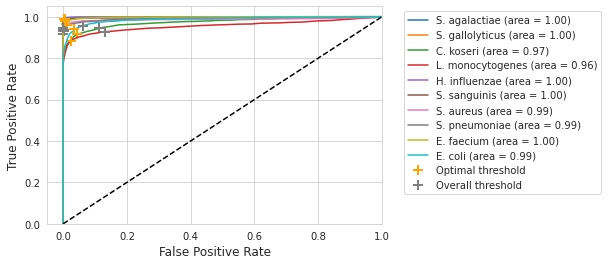

/tmp/ipykernel_36346/1389180293.py:45: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  optimal_vs_real.loc['Mean'] = optimal_vs_real.mean(axis=0)


,Left-out species,Nr. Curves,Weight,Optimal threshold,Optimal specificity,Optimal sensitivity,Optimal Youden Index,Practical threshold,Practical specificity,Practical sensitivity,Practical Youden Index,Youden difference (%),Weighted Youden Difference (%)
0,S. agalactiae,2250.0,0.81,0.50,1.00,0.99,0.99,0.84,1.00,0.92,0.92,-7.40,-6.02
1,S. gallolyticus,2010.0,0.91,0.67,0.99,0.98,0.97,0.84,1.00,0.94,0.94,-3.69,-3.36
2,C. koseri,2050.0,0.89,0.89,0.96,0.91,0.87,0.84,0.89,0.94,0.83,-4.58,-4.08
3,L. monocytogenes,2240.0,0.81,0.90,0.98,0.88,0.86,0.84,0.87,0.93,0.80,-7.41,-6.04
4,H. influenzae,2260.0,0.81,0.52,1.00,0.99,0.99,0.84,1.00,0.93,0.93,-5.71,-4.61
5,S. sanguinis,2200.0,0.83,0.60,0.99,0.99,0.98,0.84,1.00,0.94,0.94,-4.23,-3.51
6,S. aureus,2030.0,0.90,0.76,0.99,0.96,0.95,0.84,1.00,0.93,0.93,-3.12,-2.81
7,S. pneumoniae,1260.0,1.46,0.77,0.99,0.96,0.95,0.84,1.00,0.94,0.94,-1.11,-1.61
8,E. faecium,1140.0,1.61,0.70,0.99,0.98,0.97,0.84,1.00,0.94,0.94,-2.82,-4.53
9,E. coli,840.0,2.17,0.88,0.96,0.94,0.90,0.84,0.94,0.96,0.89,-1.15,-2.49


In [149]:
optimal_vs_real= []
# Plot ROC curve from accumulated experiments 
for i,label in enumerate(fig2select['species'].values):
    # Load values
    fpr = fig2select[fig2select['species']==label]['fpr'].values[0]
    tpr = fig2select[fig2select['species']==label]['tpr'].values[0]
    thresholds = fig2select[fig2select['species']==label]['thresholds'].values[0]
    roc_auc = fig2select['auc'].values[i]
    # Calculate youden
    youden_index = tpr - fpr 
    threshold = thresholds[np.argmax(youden_index)]
    fpr_thresh = fpr[np.argmax(youden_index)]
    tpr_thresh = tpr[np.argmax(youden_index)]
    
    plt.plot(fpr, tpr, label='%s (area = %0.2f)' %(label,roc_auc))
    plt.plot(fpr_thresh, tpr_thresh, '+', mew=2, ms=10, label='Optimal threshold' if i==9 else '', color='orange')
    
     #  Find threshold near accumulated_threshold
    idx = find_nearest(thresholds, acc_thresh)
    # Plot suboptimal accumulated_threshold marker
    plt.plot(fpr[idx], tpr[idx], 'y+', mew=2, ms=10, label='Overall threshold' if i==9 else '', color='grey')  
    # Save data to compare optimal vs real threshold
    optimal_vs_real.append([label, threshold, 1-fpr_thresh, tpr_thresh, tpr_thresh-fpr_thresh, acc_thresh, 1-fpr[idx], tpr[idx], tpr[idx]-fpr[idx]])

plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

#     plt.savefig('Lennart Figures/LOO classifier comparison/ROC/'+method)
plt.show()

optimal_vs_real = pd.DataFrame(optimal_vs_real)
optimal_vs_real.columns = ('Left-out species', 'Optimal threshold', "Optimal specificity", "Optimal sensitivity", "Optimal Youden Index", 'Practical threshold', "Practical specificity", "Practical sensitivity", "Practical Youden Index")
optimal_vs_real['Youden difference (%)'] = 100*(optimal_vs_real['Practical Youden Index'] - optimal_vs_real['Optimal Youden Index'])/optimal_vs_real['Optimal Youden Index']
# optimal_vs_real = pd.concat([optimal_vs_real,dfs10weights], axis=1)

optimal_vs_real.insert(1,'Nr. Curves',dfs10weights['Nr. Curves'].values)
optimal_vs_real.insert(2,'Weight',dfs10weights['Weight'].values)

optimal_vs_real['Weighted Youden Difference (%)'] = optimal_vs_real['Weight']*optimal_vs_real['Youden difference (%)']
optimal_vs_real.loc['Mean'] = optimal_vs_real.mean(axis=0)
optimal_vs_real = optimal_vs_real.round({'Optimal threshold':2, "Optimal specificity":2, "Optimal sensitivity":2, "Optimal Youden Index":2, 'Practical Threshold':2, "Practical specificity":2, "Practical sensitivity":2, "Practical Youden Index":2, 'Youden difference (%)':2,'Weighted Youden Difference (%)':2, 'Nr. Curves':-1,'Weight':2})

optimal_vs_real

# Table 2

In [150]:
save_opt_real = optimal_vs_real.sort_values('Left-out species').drop(['Nr. Curves', 'Weight', 'Weighted Youden Difference (%)'], axis=1)
# to_word(save_opt_real, False)
save_opt_real

,Left-out species,Optimal threshold,Optimal specificity,Optimal sensitivity,Optimal Youden Index,Practical threshold,Practical specificity,Practical sensitivity,Practical Youden Index,Youden difference (%)
2,C. koseri,0.89,0.96,0.91,0.87,0.84,0.89,0.94,0.83,-4.58
9,E. coli,0.88,0.96,0.94,0.90,0.84,0.94,0.96,0.89,-1.15
8,E. faecium,0.70,0.99,0.98,0.97,0.84,1.00,0.94,0.94,-2.82
4,H. influenzae,0.52,1.00,0.99,0.99,0.84,1.00,0.93,0.93,-5.71
3,L. monocytogenes,0.90,0.98,0.88,0.86,0.84,0.87,0.93,0.80,-7.41
0,S. agalactiae,0.50,1.00,0.99,0.99,0.84,1.00,0.92,0.92,-7.40
6,S. aureus,0.76,0.99,0.96,0.95,0.84,1.00,0.93,0.93,-3.12
1,S. gallolyticus,0.67,0.99,0.98,0.97,0.84,1.00,0.94,0.94,-3.69
7,S. pneumoniae,0.77,0.99,0.96,0.95,0.84,1.00,0.94,0.94,-1.11
5,S. sanguinis,0.60,0.99,0.99,0.98,0.84,1.00,0.94,0.94,-4.23


# Bar Chart Practical Youden Index

In [133]:
save_folder = './outputs/'

In [83]:
fig2 = pd.read_pickle(save_folder+'roc_curves.pkl')
fig2ov = pd.read_pickle(save_folder+'accumulate.pkl')
fig2['short'] = 1
fig2ov['short'] = 1


fig2_full = pd.read_pickle(save_folder_full+'roc_curves.pkl')
fig2ov_full = pd.read_pickle(save_folder_full+'accumulate.pkl')

fig2 = pd.concat((fig2, fig2_full))
fig2ov = pd.concat((fig2ov, fig2ov_full))

for z in range(2):
    pract_Ys = []
    for clf_name in classifiers_names:
        fig2select = fig2[(fig2['method']==clf_name) & (fig2['novelty_method']=='prob_all') & (fig2['short']==z)]

        # Get accumulated threshold
        fig2ovselect = fig2ov[(fig2ov['method']==clf_name) & (fig2ov['novelty_method']=='prob_all') & (fig2ov['short']==z)]
        acc_thresh = accumulated_ROC(fig2ovselect)

        pract_Y = []
        for i,label in enumerate(fig2select['species'].values):
            # Load values
            fpr = fig2select[fig2select['species']==label]['fpr'].values[0]
            tpr = fig2select[fig2select['species']==label]['tpr'].values[0]
            thresholds = fig2select[fig2select['species']==label]['thresholds'].values[0]
            roc_auc = fig2select['auc'].values[i]
            # Calculate youden
            youden_index = tpr - fpr 
            threshold = thresholds[np.argmax(youden_index)]
            fpr_thresh = fpr[np.argmax(youden_index)]
            tpr_thresh = tpr[np.argmax(youden_index)]

            #  Find threshold near accumulated_threshold
            idx = find_nearest(thresholds, acc_thresh)

            # Save data to compare optimal vs real threshold
            pract_Y.append([tpr_thresh-fpr_thresh, tpr[idx]-fpr[idx]])
        pract_Ys.append(np.mean(pract_Y, axis=0)) 
    if(z==0):
        pract_Ys_df = pd.DataFrame(pract_Ys, index=classifiers_names) 
    if(z==1):
        pract_Ys_df = pd.concat([pract_Ys_df, pd.DataFrame(pract_Ys, index=classifiers_names)], axis=1)

0.9887260545229873 0.86
0.990431187087443 0.83
0.9910486869030684 0.84
0.9912506190913313 0.88
0.9922827557261283 0.87
0.9921872689341387 0.866


In [84]:
# original
fig2 = pd.read_pickle(save_folder+'roc_curves.pkl')
fig2ov = pd.read_pickle(save_folder+'accumulate.pkl')

for z in range(2):
    pract_Ys = []
    for clf_name in classifiers_names:
        fig2select = fig2[(fig2['method']==clf_name) & (fig2['novelty_method']=='prob_all') & (fig2['short']==z)]

        # Get accumulated threshold
        fig2ovselect = fig2ov[(fig2ov['method']==clf_name) & (fig2ov['novelty_method']=='prob_all') & (fig2ov['short']==z)]
        acc_thresh = accumulated_ROC(fig2ovselect)

        pract_Y = []
        for i,label in enumerate(fig2select['species'].values):
            # Load values
            fpr = fig2select[fig2select['species']==label]['fpr'].values[0]
            tpr = fig2select[fig2select['species']==label]['tpr'].values[0]
            thresholds = fig2select[fig2select['species']==label]['thresholds'].values[0]
            roc_auc = fig2select['auc'].values[i]
            # Calculate youden
            youden_index = tpr - fpr 
            threshold = thresholds[np.argmax(youden_index)]
            fpr_thresh = fpr[np.argmax(youden_index)]
            tpr_thresh = tpr[np.argmax(youden_index)]

            #  Find threshold near accumulated_threshold
            idx = find_nearest(thresholds, acc_thresh)

            # Save data to compare optimal vs real threshold
            pract_Y.append([tpr_thresh-fpr_thresh, tpr[idx]-fpr[idx]])
        pract_Ys.append(np.mean(pract_Y, axis=0)) 
    if(z==0):
        pract_Ys_df = pd.DataFrame(pract_Ys, index=classifiers_names) 
    if(z==1):
        pract_Ys_df = pd.concat([pract_Ys_df, pd.DataFrame(pract_Ys, index=classifiers_names)], axis=1)


0.9912506190913313 0.88
0.9922827557261283 0.87
0.9921872689341387 0.866


ValueError: need at least one array to concatenate

In [160]:
pract_Ys_df

,0,1,0,1
LogisticRegression,0.686433,0.661205,0.662729,0.637987
Gaussian NB,0.161137,0.159428,0.219945,0.216812
"Gaussian NB, calibrated",0.440777,0.197145,0.339737,0.064007
SVM kernel=rbf,0.771067,0.646270,0.864426,0.743508
SVM kernel=linear,0.791192,0.761846,0.771560,0.729230
Neural net activation=identity,0.640058,0.621321,0.584713,0.571076
Neural net activation=logistic,0.851065,0.799614,0.863693,0.824465
Neural net activation=tanh,0.814377,0.773163,0.810700,0.765066
Neural net activation=relu,0.771408,0.736173,0.751845,0.738651
RandF n=50,0.937415,0.892885,0.940198,0.903839


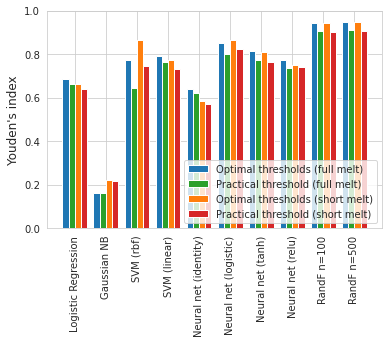

In [163]:
toplot = [0,1,3,4,5,6,7,8,10,11]
for i,j in enumerate(toplot):
    plt.bar(i-.3,pract_Ys_df.iloc[j,0],color='C0', width=0.2, label='Optimal thresholds (full melt)' if i==0 else '')
    plt.bar(i-.1,pract_Ys_df.iloc[j,1],color='C2', width=0.2, label='Practical threshold (full melt)' if i==0 else '')
    plt.bar(i+.1,pract_Ys_df.iloc[j,2],color='C1', width=0.2, label='Optimal thresholds (short melt)' if i==0 else '')
    plt.bar(i+.3,pract_Ys_df.iloc[j,3],color='C3', width=0.2, label='Practical threshold (short melt)' if i==0 else '')
plt.xticks(np.arange(len(toplot)), classifiers_names_article, rotation='vertical')
plt.ylabel("Youden's index", fontsize=12) 
plt.legend(loc='lower right')
plt.ylim(0,1.0)
plt.savefig('../../reports/figures/Figure5.svg', bbox_inches='tight')
plt.show()

# Figure 2 together

0.9891378689987533 0.888


/tmp/ipykernel_36346/2264448479.py:58: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "y+" (-> color='y'). The keyword argument will take precedence.
  ax.plot(fpr[idx], tpr[idx], 'y+', mew=2, ms=10, label='Practical threshold' if i==9 else '', color='grey')
/tmp/ipykernel_36346/2264448479.py:58: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "y+" (-> color='y'). The keyword argument will take precedence.
  ax.plot(fpr[idx], tpr[idx], 'y+', mew=2, ms=10, label='Practical threshold' if i==9 else '', color='grey')
/tmp/ipykernel_36346/2264448479.py:58: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "y+" (-> color='y'). The keyword argument will take precedence.
  ax.plot(fpr[idx], tpr[idx], 'y+', mew=2, ms=10, label='Practical threshold' if i==9 else '', color='grey')
/tmp/ipykernel_36346/2264448479.py:58: UserWarning: color is redundantly defined by t

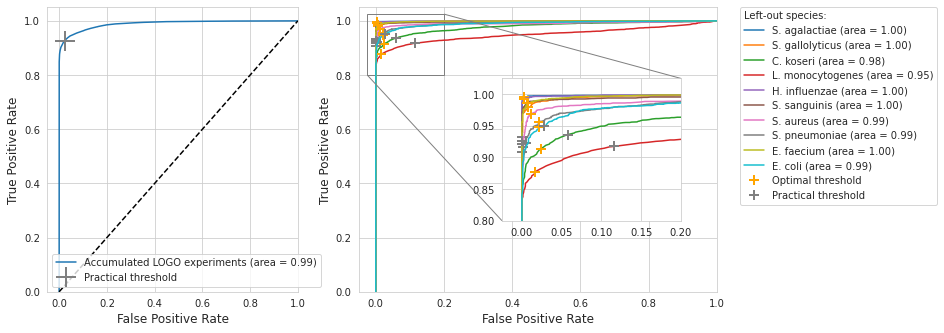

In [164]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6.96/1.33), gridspec_kw={'width_ratios': [1.4, 2]})

y_true = np.concatenate(fig2ovselect['Known'].values)
y_scores = np.concatenate(fig2ovselect['Probability'].values)
y_weights = np.concatenate(fig2ovselect['weights'].values)

fpr, tpr, thresholds = roc_curve(y_true, y_scores)  
roc_auc_all = auc(fpr, tpr)
youden_index = tpr - fpr 
acc_thresh = thresholds[np.argmax(youden_index)]
fpr_thresh = fpr[np.argmax(youden_index)]
tpr_thresh = tpr[np.argmax(youden_index)]
print(roc_auc_all, acc_thresh)

ax1.plot(fpr, tpr, label='Accumulated LOGO experiments (area = %0.2f)' %(roc_auc_all))
ax1.plot(fpr_thresh, tpr_thresh, '+', mew=2, ms=20, label='Practical threshold', color='grey')

ax1.plot([0, 1], [0, 1], color='black', linestyle='--')
ax1.set_xlim([-0.05, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate', fontsize=12)
ax1.set_ylabel('True Positive Rate', fontsize=12)

ax1.legend(loc='lower left')

# Second figure
# Create a set of inset Axes: these should fill the bounding box allocated to
# them.
ax3 = plt.axes([0,0,1,1])
# Manually set the position and relative size of the inset axes within ax1
ip = InsetPosition(ax2, [0.4,0.25,0.5,0.5])
ax3.set_axes_locator(ip)

# Mark the region corresponding to the inset axes on ax1 and draw lines
# in grey linking the two axes.
mark_inset(ax2, ax3, loc1=1, loc2=3, fc="none", ec='0.5', linewidth=1)

for i,label in enumerate(fig2select['species'].values):
    # Load values
    fpr = fig2select[fig2select['species']==label]['fpr'].values[0]
    tpr = fig2select[fig2select['species']==label]['tpr'].values[0]
    thresholds = fig2select[fig2select['species']==label]['thresholds'].values[0]
    roc_auc = fig2select['auc'].values[i]
    # Calculate youden
    youden_index = tpr - fpr 
    threshold = thresholds[np.argmax(youden_index)]
    fpr_thresh = fpr[np.argmax(youden_index)]
    tpr_thresh = tpr[np.argmax(youden_index)]
    
    #  Find threshold near accumulated_threshold
    idx = find_nearest(thresholds, acc_thresh)
    
    for ax in [ax2,ax3]:
        ax.plot(fpr, tpr, label='%s (area = %0.2f)' %(label,roc_auc))
        ax.plot(fpr_thresh, tpr_thresh, '+', mew=2, ms=10, label='Optimal threshold' if i==9 else '', color='orange')
    
        # Plot suboptimal accumulated_threshold marker
        ax.plot(fpr[idx], tpr[idx], 'y+', mew=2, ms=10, label='Practical threshold' if i==9 else '', color='grey') 
        
#     # Save data to compare optimal vs real threshold
#     optimal_vs_real.append([label, threshold, 1-fpr_thresh, tpr_thresh, tpr_thresh-fpr_thresh, acc_thresh, 1-fpr[idx], tpr[idx], tpr[idx]-fpr[idx]])
   
ax2.set_xlim([-0.05, 1.0])
ax2.set_ylim([0.0, 1.05])
ax3.set_xlim([-0.025, 0.2])
ax3.set_ylim([0.8, 1.025])
ax2.set_xlabel('False Positive Rate', fontsize=12)
ax2.set_ylabel('True Positive Rate', fontsize=12)

leg = ax2.legend(bbox_to_anchor=(1.05, 1.02), loc='upper left', title='Left-out species:')
leg._legend_box.align = "left"

plt.savefig(save_folder + 'Figure4_v2.svg', bbox_inches='tight')
plt.show()


### See if I can find better threshold --> I can not

In [334]:
def f(acc_thresh):
    optimal_vs_real= []
    # Plot ROC curve from accumulated experiments 
    for i,label in enumerate(fig2select['species'].values):
        # Load values
        fpr = fig2select[fig2select['species']==label]['fpr'].values[0]
        tpr = fig2select[fig2select['species']==label]['tpr'].values[0]
        thresholds = fig2select[fig2select['species']==label]['thresholds'].values[0]
        roc_auc = fig2select['auc'].values[i]
        # Calculate youden
        youden_index = tpr - fpr 
        threshold = thresholds[np.argmax(youden_index)]
        fpr_thresh = fpr[np.argmax(youden_index)]
        tpr_thresh = tpr[np.argmax(youden_index)]

        #  Find threshold near accumulated_threshold
        idx = find_nearest(thresholds, acc_thresh)
        # Save data to compare optimal vs real threshold
        optimal_vs_real.append([labels[i], threshold, 1-fpr_thresh, tpr_thresh, tpr_thresh-fpr_thresh, acc_thresh, 1-fpr[idx], tpr[idx], tpr[idx]-fpr[idx]])

    optimal_vs_real = pd.DataFrame(optimal_vs_real)
    optimal_vs_real.columns = ('Left-out species', 'Optimal Threshold', "Optimal specificity", "Optimal sensitivity", "Optimal Youden index", 'Real Threshold', "Real specificity", "Real sensitivity", "Real Youden index")
    optimal_vs_real['Youden difference (%)'] = 100*(optimal_vs_real['Real Youden index'] - optimal_vs_real['Optimal Youden index'])/optimal_vs_real['Optimal Youden index']
    optimal_vs_real.loc['Mean'] = optimal_vs_real.mean(axis=0)
    # optimal_vs_real = optimal_vs_real.round({'Optimal Threshold':4, "Optimal specificity":2, "Optimal sensitivity":2, "Optimal Youden index":2, 'Real Threshold':5, "Real specificity":2, "Real sensitivity":2, "Real Youden index":2, 'Youden difference (%)':2})
    
    return -optimal_vs_real.loc['Mean']['Youden difference (%)']

In [347]:
from scipy import optimize
minimum = optimize.fmin(f, acc_thresh)
print(minimum[0])

nearest difference: 0.0
nearest difference: 0.0
nearest difference: 0.0
nearest difference: 0.0
nearest difference: 0.0
nearest difference: 0.0
nearest difference: 0.0
nearest difference: 0.0
nearest difference: 0.0
nearest difference: 0.0
nearest difference: 0.0014999999999999458
nearest difference: 0.0014999999999999458
nearest difference: 0.0014999999999999458
nearest difference: 0.0014999999999999458
nearest difference: 0.0014999999999999458
nearest difference: 0.0014999999999999458
nearest difference: 0.0014999999999999458
nearest difference: 0.0014999999999999458
nearest difference: 0.0014999999999999458
nearest difference: 0.0014999999999999458
nearest difference: 0.0015000000000000568
nearest difference: 0.0015000000000000568
nearest difference: 0.0015000000000000568
nearest difference: 0.0015000000000000568
nearest difference: 0.0015000000000000568
nearest difference: 0.0015000000000000568
nearest difference: 0.0015000000000000568
nearest difference: 0.0015000000000000568
near

### With weights --> still can not

In [812]:
def f_weights(acc_thresh):
    optimal_vs_real= []
    # Plot ROC curve from accumulated experiments 
    for i,label in enumerate(fig2select['species'].values):
        # Load values
        fpr = fig2select[fig2select['species']==label]['fpr'].values[0]
        tpr = fig2select[fig2select['species']==label]['tpr'].values[0]
        thresholds = fig2select[fig2select['species']==label]['thresholds'].values[0]
        roc_auc = fig2select['auc'].values[i]
        # Calculate youden
        youden_index = tpr - fpr 
        threshold = thresholds[np.argmax(youden_index)]
        fpr_thresh = fpr[np.argmax(youden_index)]
        tpr_thresh = tpr[np.argmax(youden_index)]

        #  Find threshold near accumulated_threshold
        idx = find_nearest(thresholds, acc_thresh)
        # Save data to compare optimal vs real threshold
        optimal_vs_real.append([label, threshold, 1-fpr_thresh, tpr_thresh, tpr_thresh-fpr_thresh, acc_thresh, 1-fpr[idx], tpr[idx], tpr[idx]-fpr[idx]])

    optimal_vs_real = pd.DataFrame(optimal_vs_real)
    optimal_vs_real.columns = ('Left-out species', 'Optimal Threshold', "Optimal specificity", "Optimal sensitivity", "Optimal Youden index", 'Real Threshold', "Real specificity", "Real sensitivity", "Real Youden index")
    optimal_vs_real['Youden difference (%)'] = 100*(optimal_vs_real['Real Youden index'] - optimal_vs_real['Optimal Youden index'])/optimal_vs_real['Optimal Youden index']
    # optimal_vs_real = optimal_vs_real.round({'Optimal Threshold':4, "Optimal specificity":2, "Optimal sensitivity":2, "Optimal Youden index":2, 'Real Threshold':5, "Real specificity":2, "Real sensitivity":2, "Real Youden index":2, 'Youden difference (%)':2})
    dfs10weights.index = range(10)
    optimal_vs_real = pd.concat([optimal_vs_real,dfs10weights], axis=1)
    optimal_vs_real['Weighted Youden Difference (%)'] = optimal_vs_real['Weight']*optimal_vs_real['Youden difference (%)']
    optimal_vs_real.loc['Mean'] = optimal_vs_real.mean(axis=0)
    print(-optimal_vs_real.loc['Mean']['Weighted Youden Difference (%)'])
    
    return -optimal_vs_real.loc['Mean']['Weighted Youden Difference (%)']
#     return optimal_vs_real

In [813]:
f_weights(0.7)

11.576417959221747


11.576417959221747

In [816]:
from scipy import optimize
minimum = optimize.fmin(f_weights, 0.7)
print(minimum[0])
print('acc_thresh',acc_thresh)

11.576417959221747
8.583660843439187
6.4482368484899935
4.513369275747262
4.60673765314637
3.9060900416928077
4.60673765314637
4.261534523721025
3.971913861472231
3.95533288177027
3.9393248560276306
3.9060900416928077
3.9060900416928077
3.9060900416928077
3.9060900416928077
3.9060900416928077
3.9060900416928077
3.9060900416928077
3.9060900416928077
3.9060900416928077
3.9060900416928077
3.9060900416928077
3.9060900416928077
3.9060900416928077
3.9060900416928077
3.9060900416928077
3.9060900416928077
3.9060900416928077
3.9060900416928077
3.9060900416928077
Optimization terminated successfully.
         Current function value: 3.906090
         Iterations: 12
         Function evaluations: 30
0.8400000000000003
acc_thresh 0.84


# 3) uMelts for extra validation (Figure 3)

In [85]:
save_folder = './outputs/'

In [86]:
fig2ov = pd.read_pickle(save_folder+'accumulate.pkl')

In [87]:
# Get all accumulated thresholds
acc_thresholds = []
df_fig_save = fig2ov
for method in df_fig_save[df_fig_save['novelty_method']=='prob_all']['method'].values:
    fig2ovselect = fig2ov[(fig2ov['method']==method) & (fig2ov['novelty_method']=='prob_all') & (fig2ov['short']==0)]
    print(method)
    acc_thresholds.append(accumulated_ROC(fig2ovselect))

LogisticRegression
0.906114347691864 0.9992012142636737
Gaussian NB
0.5636265806307358 1.0
Gaussian NB, calibrated
0.5920236270367267 0.9675564948091576
SVM kernel=rbf
0.9717224926358529 0.9803567427178808
SVM kernel=linear
0.953474078678989 0.9828115013360184
Neural net activation=identity
0.8887827748160071 0.9999956989961265
Neural net activation=logistic
0.9720563652229383 0.9990703042578322
Neural net activation=tanh
0.9672503183073135 0.999565076150296
Neural net activation=relu
0.9453447132612958 0.9999183606679448
RandF n=50
0.9912506190913313 0.88
RandF n=100
0.9922827557261283 0.87
RandF n=500
0.9921872689341387 0.866
LogisticRegression
0.906114347691864 0.9992012142636737
Gaussian NB
0.5636265806307358 1.0
Gaussian NB, calibrated
0.5920236270367267 0.9675564948091576
SVM kernel=rbf
0.9717224926358529 0.9803567427178808
SVM kernel=linear
0.953474078678989 0.9828115013360184
Neural net activation=identity
0.8887827748160071 0.9999956989961265
Neural net activation=logistic
0.9

In [198]:
save_folder = './outputs/'

In [89]:
# save_folder = 'Lennart Figures/LOO classifier comparison5/'
df_roc_curves = pd.read_pickle(save_folder+'uMelt_roc_curves0.pkl')
df_fig_save = pd.read_pickle(save_folder+'uMelt_fig_save0.pkl')

/tmp/ipykernel_39761/3012459227.py:38: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "y+" (-> color='y'). The keyword argument will take precedence.
  ax2.plot(fpr[idx], tpr[idx], 'y+', mew=2, ms=10, label='Practical threshold', color='grey')


LogisticRegression


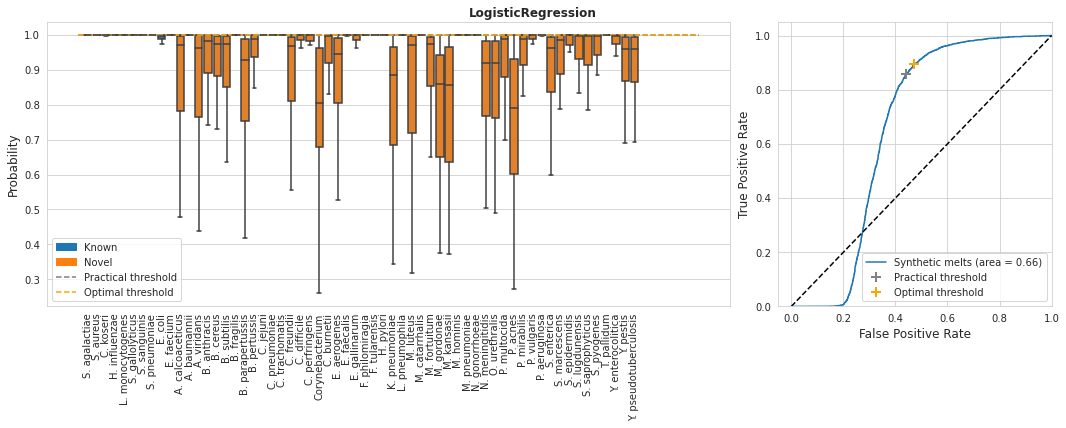

/tmp/ipykernel_39761/3012459227.py:38: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "y+" (-> color='y'). The keyword argument will take precedence.
  ax2.plot(fpr[idx], tpr[idx], 'y+', mew=2, ms=10, label='Practical threshold', color='grey')


Gaussian NB


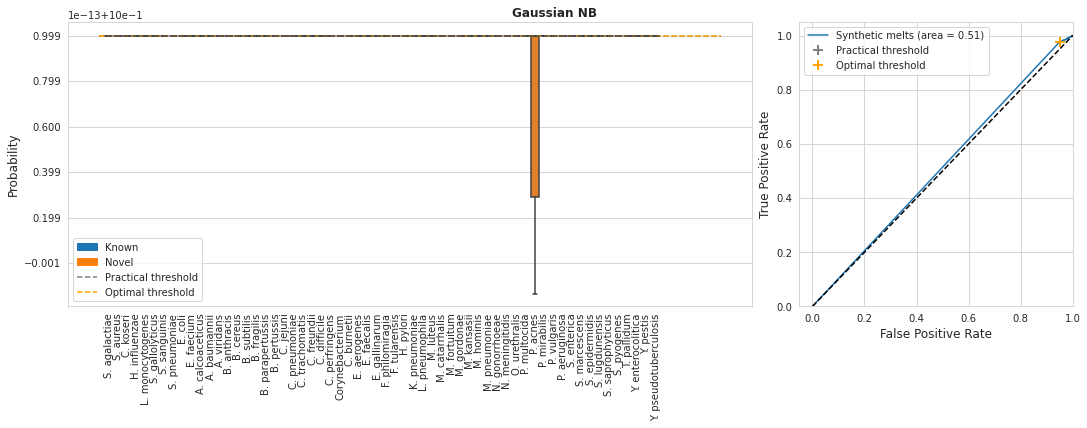

/tmp/ipykernel_39761/3012459227.py:38: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "y+" (-> color='y'). The keyword argument will take precedence.
  ax2.plot(fpr[idx], tpr[idx], 'y+', mew=2, ms=10, label='Practical threshold', color='grey')


Gaussian NB, calibrated


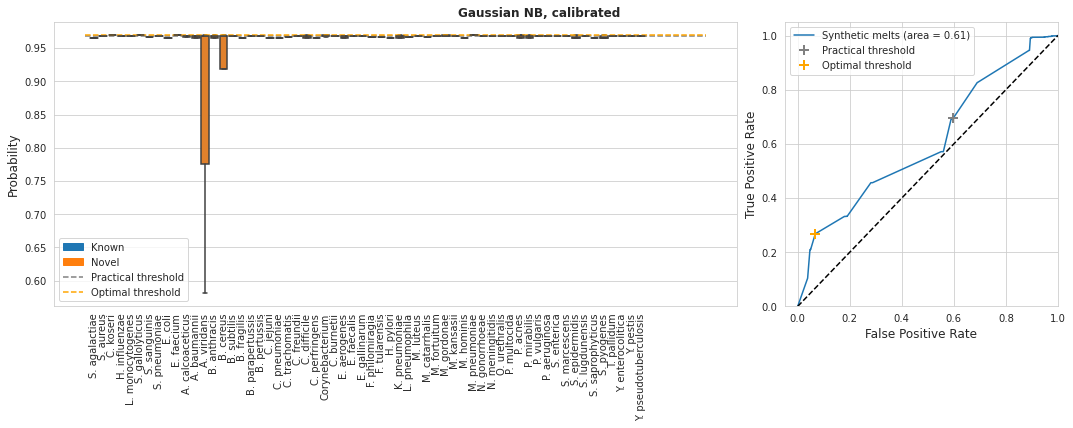

/tmp/ipykernel_39761/3012459227.py:38: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "y+" (-> color='y'). The keyword argument will take precedence.
  ax2.plot(fpr[idx], tpr[idx], 'y+', mew=2, ms=10, label='Practical threshold', color='grey')


SVM kernel=rbf


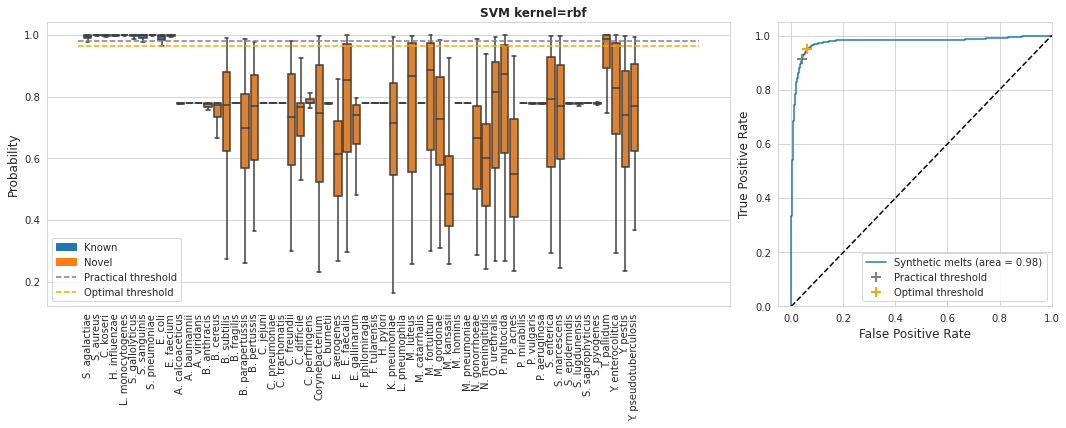

/tmp/ipykernel_39761/3012459227.py:38: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "y+" (-> color='y'). The keyword argument will take precedence.
  ax2.plot(fpr[idx], tpr[idx], 'y+', mew=2, ms=10, label='Practical threshold', color='grey')


SVM kernel=linear


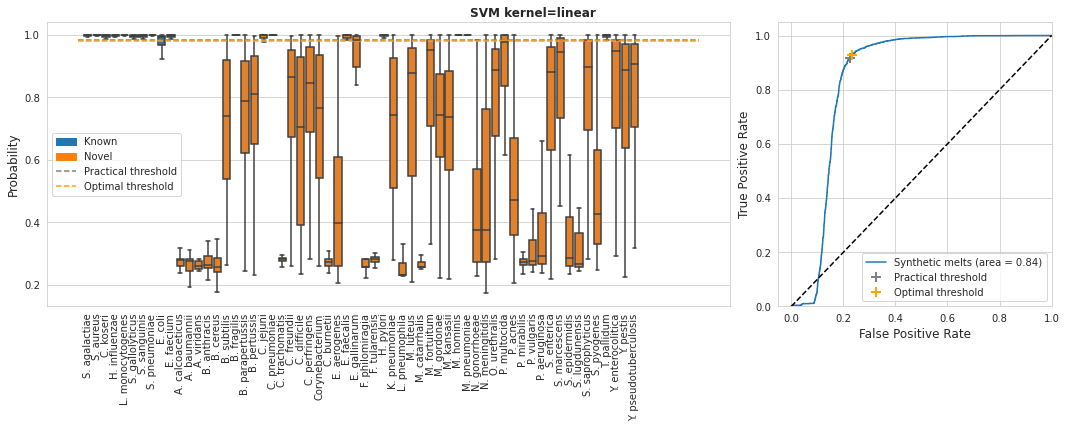

/tmp/ipykernel_39761/3012459227.py:38: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "y+" (-> color='y'). The keyword argument will take precedence.
  ax2.plot(fpr[idx], tpr[idx], 'y+', mew=2, ms=10, label='Practical threshold', color='grey')


Neural net activation=identity


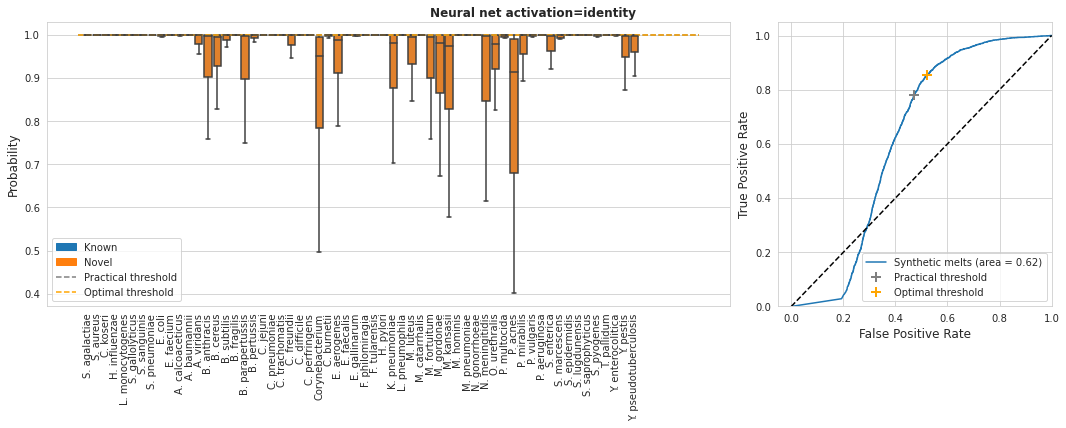

/tmp/ipykernel_39761/3012459227.py:38: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "y+" (-> color='y'). The keyword argument will take precedence.
  ax2.plot(fpr[idx], tpr[idx], 'y+', mew=2, ms=10, label='Practical threshold', color='grey')


Neural net activation=logistic


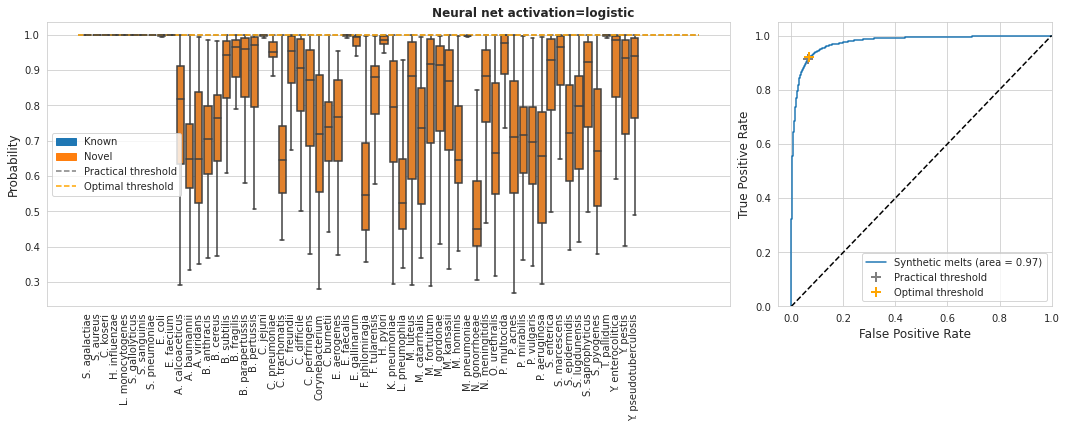

/tmp/ipykernel_39761/3012459227.py:38: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "y+" (-> color='y'). The keyword argument will take precedence.
  ax2.plot(fpr[idx], tpr[idx], 'y+', mew=2, ms=10, label='Practical threshold', color='grey')


Neural net activation=tanh


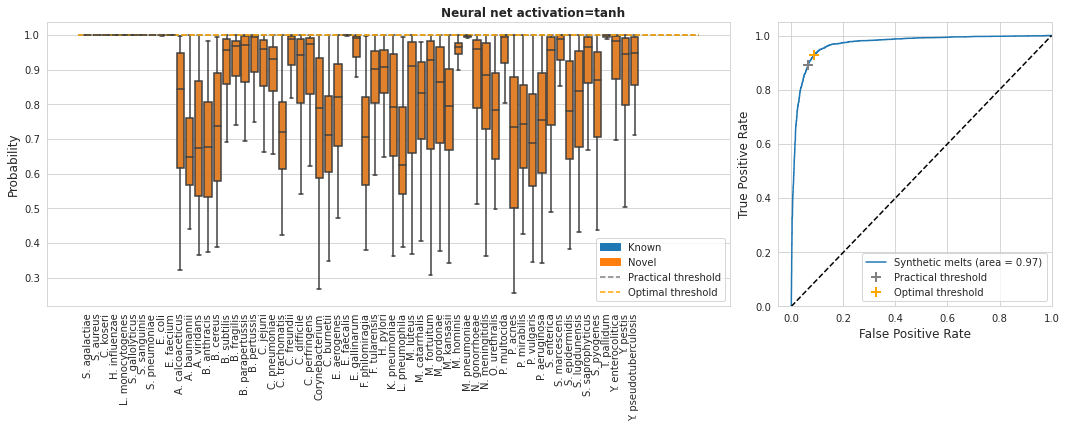

/tmp/ipykernel_39761/3012459227.py:38: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "y+" (-> color='y'). The keyword argument will take precedence.
  ax2.plot(fpr[idx], tpr[idx], 'y+', mew=2, ms=10, label='Practical threshold', color='grey')


Neural net activation=relu


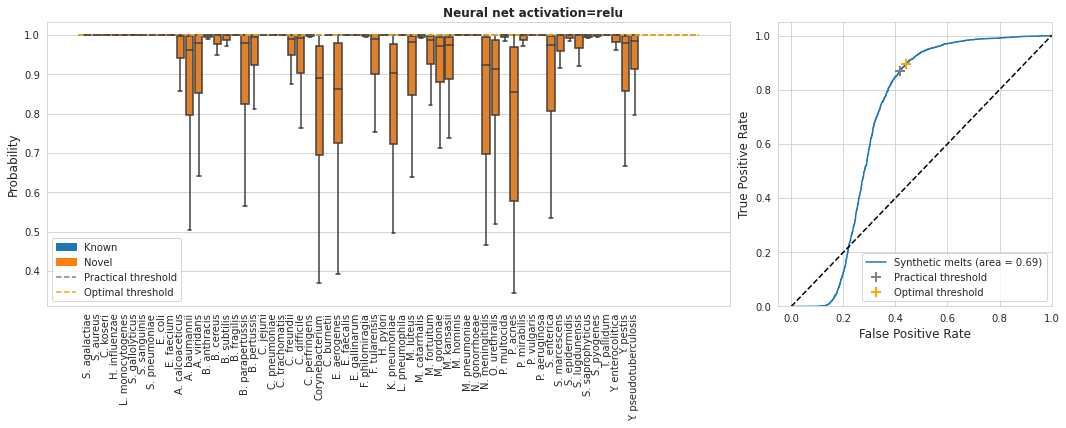

/tmp/ipykernel_39761/3012459227.py:38: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "y+" (-> color='y'). The keyword argument will take precedence.
  ax2.plot(fpr[idx], tpr[idx], 'y+', mew=2, ms=10, label='Practical threshold', color='grey')


RandF n=50


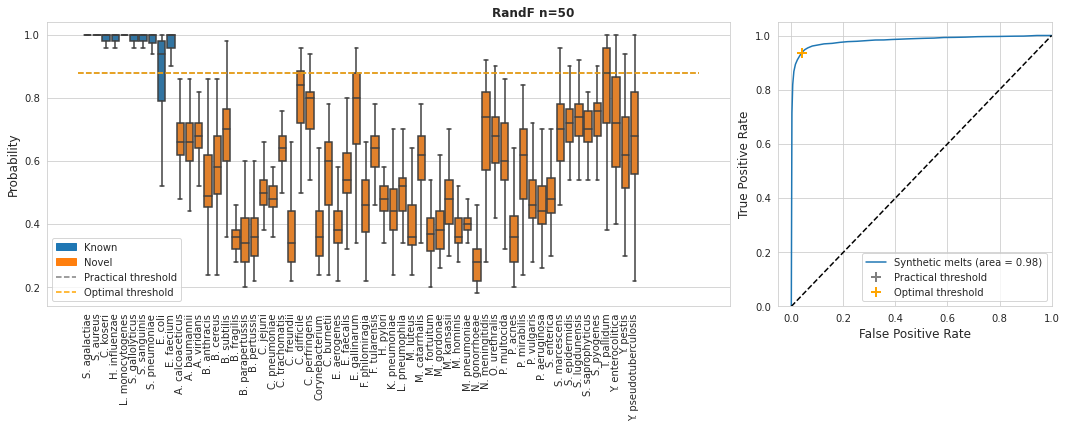

/tmp/ipykernel_39761/3012459227.py:38: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "y+" (-> color='y'). The keyword argument will take precedence.
  ax2.plot(fpr[idx], tpr[idx], 'y+', mew=2, ms=10, label='Practical threshold', color='grey')


RandF n=100


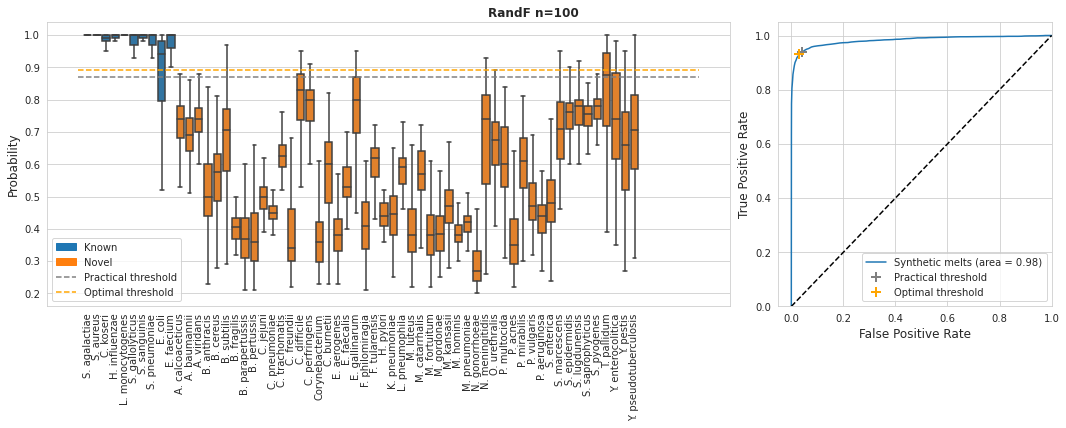

/tmp/ipykernel_39761/3012459227.py:38: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "y+" (-> color='y'). The keyword argument will take precedence.
  ax2.plot(fpr[idx], tpr[idx], 'y+', mew=2, ms=10, label='Practical threshold', color='grey')


RandF n=500


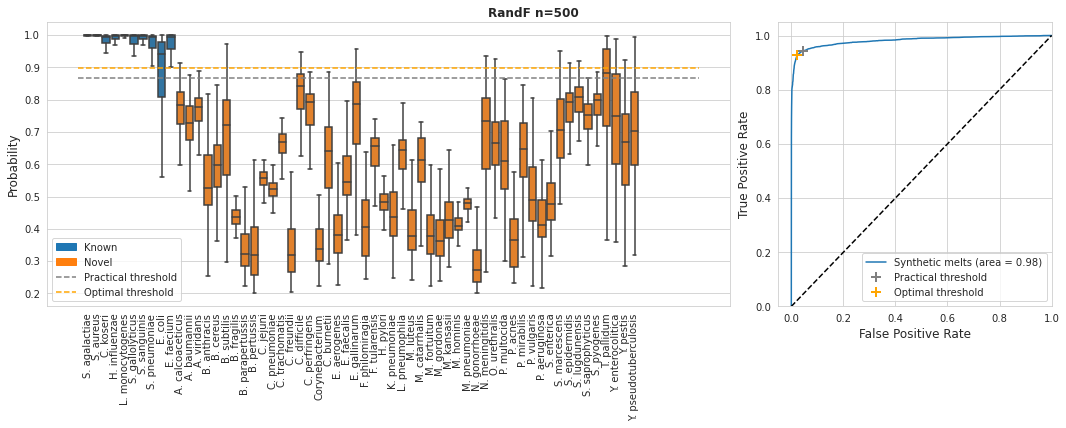

In [97]:
compare_sens_spec = []
for method, thresh in zip(df_fig_save[df_fig_save['novelty_method']=='prob_all']['method'].values, acc_thresholds):
    select = df_fig_save[(df_fig_save['novelty_method']=='prob_all') & (df_fig_save['method']==method)]
    select_roc = df_roc_curves[(df_roc_curves['novelty_method']=='prob_all') & (df_roc_curves['method']==method)]
  
    compare_sens_spec.append(plot_boxplot_simple(select['index'].values[0], select['score'].values[0], select_roc['fpr'].values[0], select_roc['tpr'].values[0], select_roc['thresholds'].values[0],select_roc['auc'].values[0], select_roc['threshold'].values[0], thresh, method))

# Figure 6

In [73]:
df_fig_save[df_fig_save['novelty_method']=='prob_all']['method'].values[-1:]

array(['RandF n=500'], dtype=object)

/tmp/ipykernel_36346/1906912054.py:38: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "y+" (-> color='y'). The keyword argument will take precedence.
  ax2.plot(fpr[idx], tpr[idx], 'y+', mew=2, ms=10, label='Practical threshold', color='grey')


RandF n=500


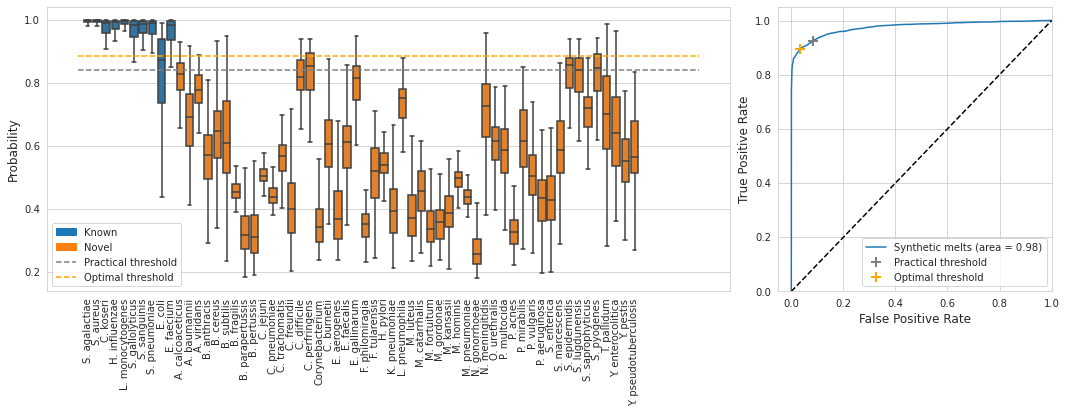

In [74]:
# compare_sens_spec = []
for method, thresh in zip(df_fig_save[df_fig_save['novelty_method']=='prob_all']['method'].values[-1:], acc_thresholds[-1:]):
    select = df_fig_save[(df_fig_save['novelty_method']=='prob_all') & (df_fig_save['method']==method)]
    select_roc = df_roc_curves[(df_roc_curves['novelty_method']=='prob_all') & (df_roc_curves['method']==method)]
  
    plot_boxplot_simple(select['index'].values[0], select['score'].values[0], select_roc['fpr'].values[0], select_roc['tpr'].values[0], select_roc['thresholds'].values[0],select_roc['auc'].values[0], select_roc['threshold'].values[0], thresh, method)

### Compare sensitivity / specificity

In [44]:
compare_sens_spec

[[0.9985012378684058,
  0.5272,
  0.8936286573694285,
  0.42082865736942854,
  0.9991341846807195,
  0.5534,
  0.8621821164889254,
  0.4155821164889254],
 [1.0,
  0.05020000000000002,
  0.976483456385015,
  0.026683456385015014,
  1.0,
  0.05020000000000002,
  0.976483456385015,
  0.026683456385015014],
 [0.9691106777319514,
  0.9322,
  0.2685261143013399,
  0.20072611430133988,
  0.9542552050583307,
  0.10399999999999998,
  0.9909762100082035,
  0.09497621000820344],
 [0.9626453576287431,
  0.9382,
  0.9499589827727646,
  0.8881589827727646,
  0.9863349109164292,
  0.9682,
  0.8826907301066448,
  0.8508907301066447],
 [0.97944834276269,
  0.7682,
  0.9286300246103364,
  0.6968300246103364,
  0.9857686478585918,
  0.7836,
  0.9048400328137818,
  0.6884400328137817],
 [0.9999760493256428,
  0.48,
  0.8558928083128248,
  0.33589280831282475,
  0.9999658662092478,
  0.46640000000000004,
  0.8651900464861909,
  0.33159004648619095],
 [0.9989516596845076,
  0.9304,
  0.9190593382554006,
  0

In [43]:
compare = pd.DataFrame(compare_sens_spec)
compare.columns = ('Optimal Threshold', "Optimal specificity", "Optimal sensitivity", "Optimal Youden index", 'Overall Threshold', "Real specificity", "Real sensitivity", "Real Youden index")
compare.index = classifiers_names
compare['Youden difference (%)'] = 100*(compare['Real Youden index'] - compare['Optimal Youden index'])/compare['Optimal Youden index']
compare

,Optimal Threshold,Optimal specificity,Optimal sensitivity,Optimal Youden index,Overall Threshold,Real specificity,Real sensitivity,Real Youden index,Youden difference (%)
LogisticRegression,0.998501,0.5272,0.893629,0.420829,0.999134,0.5534,0.862182,0.415582,-1.246717
Gaussian NB,1.000000,0.0502,0.976483,0.026683,1.000000,0.0502,0.976483,0.026683,0.000000
"Gaussian NB, calibrated",0.969111,0.9322,0.268526,0.200726,0.954255,0.1040,0.990976,0.094976,-52.683680
SVM kernel=rbf,0.962645,0.9382,0.949959,0.888159,0.986335,0.9682,0.882691,0.850891,-4.196124
SVM kernel=linear,0.979448,0.7682,0.928630,0.696830,0.985769,0.7836,0.904840,0.688440,-1.204023
Neural net activation=identity,0.999976,0.4800,0.855893,0.335893,0.999966,0.4664,0.865190,0.331590,-1.280993
Neural net activation=logistic,0.998952,0.9304,0.919059,0.849459,0.998433,0.9152,0.932732,0.847932,-0.179831
Neural net activation=tanh,0.998914,0.9116,0.929450,0.841050,0.999247,0.9222,0.913864,0.836064,-0.592895
Neural net activation=relu,0.999848,0.5612,0.894996,0.456196,0.999690,0.5306,0.916598,0.447198,-1.972309
RandF n=50,0.880000,0.9596,0.937107,0.896707,0.860000,0.9486,0.947498,0.896098,-0.067912


## Compare 4 methods (no noise/noise and short/long)

### AUC Values

In [ ]:
auc_compare=[]
for i in range(4):
    read_roc = pd.read_pickle(save_folder+'uMelt_roc_curves'+str(i)+'.pkl')
    auc_compare.append(read_roc[read_roc['novelty_method']=='prob_all']['auc'].values)
auc_compare = pd.DataFrame(auc_compare).T
auc_compare.index = read_roc[read_roc['novelty_method']=='prob_all']['method'].values
auc_compare

,0,1,2,3
LogisticRegression,0.783750,0.808234,0.750865,0.773683
Gaussian NB,0.544928,0.604189,0.569955,0.575364
"Gaussian NB, calibrated",0.333374,0.318733,0.363250,0.333669
SVM kernel=rbf,0.797936,0.944341,0.969135,0.981626
SVM kernel=linear,0.892311,0.837540,0.860213,0.819674
Neural net activation=identity,0.722285,0.810579,0.702972,0.766369
Neural net activation=logistic,0.968561,0.984622,0.964353,0.979662
Neural net activation=tanh,0.949255,0.974432,0.948502,0.970884
Neural net activation=relu,0.838056,0.794857,0.799804,0.780816
RandF n=50,0.979845,0.963526,0.983246,0.977209


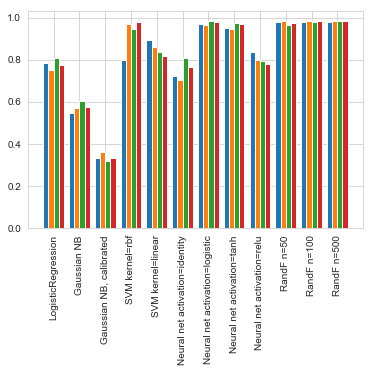

In [ ]:
for i in range(len(auc_compare)):
    plt.bar(i-.3,auc_compare.iloc[i][0],color='C0', width=0.2)
    plt.bar(i-.1,auc_compare.iloc[i][2],color='C1', width=0.2)
    plt.bar(i+.1,auc_compare.iloc[i][1],color='C2', width=0.2)
    plt.bar(i+.3,auc_compare.iloc[i][3],color='C3', width=0.2)
plt.xticks(np.arange(len(auc_compare)), auc_compare.index, rotation='vertical')
plt.show()

# Figure 7

### Real Youden Values

In [57]:
fig2ov_ne.short

AttributeError: 'DataFrame' object has no attribute 'short'

In [49]:
results_sig_ne = pd.read_csv("./outputs_sig_no_ecoli/"+'results.csv', index_col=0)
results_sig_ne['short'] = 1
results_sig2_ne = pd.read_csv("./outputs_sig_full_no_ecoli/"+'results.csv', index_col=0)

fig2ov_ne = pd.read_pickle("./outputs_sig_no_ecoli/"+'accumulate.pkl')
fig2ov_ne['short'] = 1
fig2ov2_ne = pd.read_pickle("./outputs_sig_full_no_ecoli/"+'accumulate.pkl')



results_sig_ne = pd.concat((results_sig_ne, results_sig2_ne)).to_csv("./outputs_both_no_ecoli/results.csv")
fig2ov_ne = pd.concat((fig2ov_ne, fig2ov2_ne)).to_pickle('./outputs_both_no_ecoli/accumulate.pkl')


results_sig = pd.read_csv("./outputs_sig/"+'results.csv', index_col=0)
results_sig['short'] = 1
results_sig2 = pd.read_csv("./outputs_sig_full/"+'results.csv', index_col=0)

fig2ov = pd.read_pickle("./outputs_sig/"+'accumulate.pkl')
fig2ov['short'] = 1
fig2ov2 = pd.read_pickle("./outputs_sig_full/"+'accumulate.pkl')

results_sig = pd.concat((results_sig, results_sig2)).to_csv("./outputs_both/results.csv")
fig2ov = pd.concat((fig2ov, fig2ov2)).to_pickle('./outputs_both/accumulate.pkl')


In [62]:
compare_all_ecoli

[[                                Optimal Youden  Practical Youden
  LogisticRegression                    0.492039          0.492039
  Gaussian NB                           0.011312          0.010353
  Gaussian NB, calibrated               0.263032          0.077068
  SVM kernel=rbf                        0.853467          0.836972
  SVM kernel=linear                     0.671812          0.666461
  Neural net activation=identity        0.311013          0.292112
  Neural net activation=logistic        0.824620          0.823845
  Neural net activation=tanh            0.809928          0.800397
  Neural net activation=relu            0.500126          0.498960
  RandF n=50                            0.904605          0.904605
  RandF n=100                           0.907087          0.898037
  RandF n=500                           0.902112          0.890082,
                                  Optimal Youden  Practical Youden
  LogisticRegression                    0.420829          0.4

In [72]:
# folders = ['Lennart Figures/LOO classifier comparison5/','Lennart Figures/LOO classifier comparison5/dropEc/']
folders = ['./outputs_both/','./outputs_both_no_ecoli/']

compare_all_ecoli = []
for save_folder in folders:
    fig2ov = pd.read_pickle(save_folder+'accumulate.pkl')

    compare_all = []
    for i in range(2):
        df_roc_curves = pd.read_pickle(save_folder+'uMelt_roc_curves'+str(i)+'.pkl')
        df_fig_save = pd.read_pickle(save_folder+'uMelt_fig_save'+str(i)+'.pkl')

        # Get all accumulated thresholds
        acc_thresholds = []
        for method in classifiers_names:
            fig2ovselect = fig2ov[(fig2ov['method']==method) & (fig2ov['novelty_method']=='prob_all') & (fig2ov['short']==int(i%2!=0))]
            acc_thresholds.append(accumulated_ROC(fig2ovselect))
            
    #         # Get alternative threshold
    #         acc_thresholds = []
    #         for method in df_fig_save[df_fig_save['novelty_method']=='prob_all']['method'].values:
    #             index = df_fig_save[(df_fig_save['method']==method) & (df_fig_save['novelty_method']=='prob_all')]['index'].values[0]
    #             description = df_fig_save[(df_fig_save['method']==method) & (df_fig_save['novelty_method']=='prob_all')]['score'].values[0].groupby(index).describe()
    #             iqr = description.loc[sorted(fig2select['species'].values)]['75%']-description.loc[sorted(fig2select['species'].values)]['25%']
    #             bottom_whisker = description.loc[sorted(fig2select['species'].values)]['25%'] - 1.5*iqr
    #             acc_thresholds.append(np.min(bottom_whisker))

        compare_sens_spec = []
        for method, acc_thresh in zip(classifiers_names, acc_thresholds):
            select_roc = df_roc_curves[(df_roc_curves['novelty_method']=='prob_all') & (df_roc_curves['method']==method)]
            plot_boxplot_data = plot_boxplot_simple_data(select_roc['fpr'].values[0], select_roc['tpr'].values[0], select_roc['thresholds'].values[0], acc_thresh)
            compare_sens_spec.append(plot_boxplot_data)
        
        compare_all.append(compare_sens_spec)
    compare = [pd.DataFrame(comp_all, index=classifiers_names, columns=['Optimal Youden', 'Practical Youden']) for comp_all in compare_all]
    compare_all_ecoli.append(compare)

0.9097775283655068 0.9991341846807195
0.5331529152804482 1.0
0.6453394625058078 0.9542552050583307
0.9322360741994413 0.9863349109164292
0.9491189160818406 0.9857686478585918
0.908782345646945 0.9999658662092478
0.9756699321578789 0.9984326102503286
0.972115084260331 0.9992472493218398
0.9524443721184318 0.9996900882862029
0.9887260545229873 0.86
0.990431187087443 0.83
0.9910486869030684 0.84
0.906114347691864 0.9992012142636737
0.5636265806307358 1.0
0.5920236270367267 0.9675564948091576
0.9717224926358529 0.9803567427178808
0.953474078678989 0.9828115013360184
0.8887827748160071 0.9999956989961265
0.9720563652229383 0.9990703042578322
0.9672503183073135 0.999565076150296
0.9453447132612958 0.9999183606679448
0.9912506190913313 0.88
0.9922827557261283 0.87
0.9921872689341387 0.866
0.9291633764542704 0.9988584918553916
0.5443900122437516 1.0
0.5884537378275327 0.9727874761233398
0.9263405185852192 0.9901740053499235
0.9494695939574611 0.9876164164075236
0.9265046354926916 0.99960011566

In [162]:
classifiers_names_article = ['Logistic Regression', 'Gaussian NB', 'SVM (rbf)',
       'SVM (linear)', 'Neural net (identity)',
       'Neural net (logistic)', 'Neural net (tanh)',
       'Neural net (relu)', 'RandF n=100',
       'RandF n=500']

In [63]:
len(compare_all_ecoli)

2

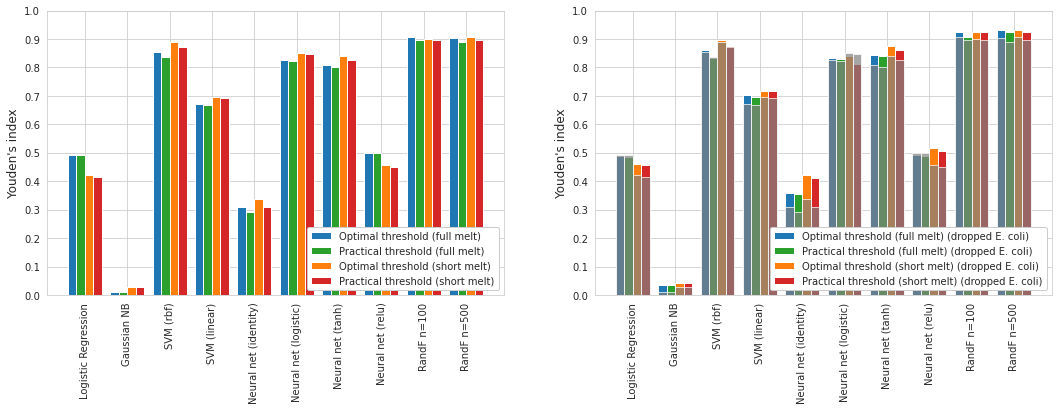

In [73]:
toplot = [0,1,3,4,5,6,7,8,10,11]
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6.96/1.33))
for i,j in enumerate(toplot):
    ax1.bar(i-.3,compare_all_ecoli[0][0].iloc[j,0],color='C0', width=0.2, label='Optimal threshold (full melt)' if i==0 else '')
    ax1.bar(i-.1,compare_all_ecoli[0][0].iloc[j,1],color='C2', width=0.2, label='Practical threshold (full melt)' if i==0 else '')
    ax1.bar(i+.1,compare_all_ecoli[0][1].iloc[j,0],color='C1', width=0.2, label='Optimal threshold (short melt)' if i==0 else '')
    ax1.bar(i+.3,compare_all_ecoli[0][1].iloc[j,1],color='C3', width=0.2, label='Practical threshold (short melt)' if i==0 else '')
ax1.set_ylabel("Youden's index", fontsize=12) 
ax1.set_xticks(np.arange(len(toplot)))
ax1.set_xticklabels(classifiers_names_article, rotation='vertical')
ax1.legend(loc='lower right',framealpha=1)
ax1.set_yticks([0.1*i for i in range(11)])
ax1.set_ylim(0,1.0)

for i,j in enumerate(toplot):
    ax2.bar(i-.3,compare_all_ecoli[1][0].iloc[j,0],color='C0', width=0.2, label='Optimal threshold (full melt) (dropped E. coli)' if i==0 else '')
    ax2.bar(i-.1,compare_all_ecoli[1][0].iloc[j,1],color='C2', width=0.2, label='Practical threshold (full melt) (dropped E. coli)' if i==0 else '')
    ax2.bar(i+.1,compare_all_ecoli[1][1].iloc[j,0],color='C1', width=0.2, label='Optimal threshold (short melt) (dropped E. coli)' if i==0 else '')
    ax2.bar(i+.3,compare_all_ecoli[1][1].iloc[j,1],color='C3', width=0.2, label='Practical threshold (short melt) (dropped E. coli)' if i==0 else '')
    ax2.bar(i-.3,compare_all_ecoli[0][0].iloc[j,0],color='grey', alpha=0.7, width=0.2)
    ax2.bar(i-.1,compare_all_ecoli[0][0].iloc[j,1],color='grey', alpha=0.7, width=0.2)
    ax2.bar(i+.1,compare_all_ecoli[0][1].iloc[j,0],color='grey', alpha=0.7, width=0.2)
    ax2.bar(i+.3,compare_all_ecoli[0][1].iloc[j,1],color='grey', alpha=0.7, width=0.2)
ax2.set_ylabel("Youden's index", fontsize=12) 
ax2.set_xticks(np.arange(len(toplot)))
ax2.set_xticklabels(classifiers_names_article, rotation='vertical')
ax2.legend(loc='lower right',framealpha=1)
ax2.set_ylim(0,1.0)
ax2.set_yticks([0.1*i for i in range(11)])

plt.savefig('../../reports/figures/Figure7_v2.svg', bbox_inches='tight')
plt.show()

In [74]:
toplot = [0,1,3,4,5,6,7,8,10,11]
diff=[]
for i,j in enumerate(toplot):
    diff.append((compare_all_ecoli[0][0].iloc[j,0]-compare_all_ecoli[0][0].iloc[j,1])/compare_all_ecoli[0][0].iloc[j,0])
    diff.append((compare_all_ecoli[0][1].iloc[j,0]-compare_all_ecoli[0][1].iloc[j,1])/compare_all_ecoli[0][1].iloc[j,0])
#     print(i, (compare_all_ecoli[0][2].iloc[j,0]-compare_all_ecoli[0][2].iloc[j,1])/compare_all_ecoli[0][2].iloc[j,0])
#     print(i, (compare_all_ecoli[0][3].iloc[j,0]-compare_all_ecoli[0][3].iloc[j,1])/compare_all_ecoli[0][3].iloc[j,0])
    
print(np.mean(diff), np.std(diff))

0.018649608624504526 0.024890903126733137


# Get sensitivity / specificity

In [75]:
folders = ['./outputs_both/','./outputs_both_no_ecoli/']

compare_all_ecoli = []
for save_folder in folders:
    fig2ov = pd.read_pickle(save_folder+'accumulate.pkl')

    compare_all = []
    for i in range(2):
        df_roc_curves = pd.read_pickle(save_folder+'uMelt_roc_curves'+str(i)+'.pkl')
        df_fig_save = pd.read_pickle(save_folder+'uMelt_fig_save'+str(i)+'.pkl')

        # Get all accumulated thresholds
        acc_thresholds = []
        for method in classifiers_names:
            fig2ovselect = fig2ov[(fig2ov['method']==method) & (fig2ov['novelty_method']=='prob_all') & (fig2ov['short']==int(i%2!=0))]
            acc_thresholds.append(accumulated_ROC(fig2ovselect))
            
        compare_sens_spec = []
        for method, acc_thresh in zip(classifiers_names, acc_thresholds):
            select_roc = df_roc_curves[(df_roc_curves['novelty_method']=='prob_all') & (df_roc_curves['method']==method)]
            plot_boxplot_data = plot_boxplot_simple_data(select_roc['fpr'].values[0], select_roc['tpr'].values[0], select_roc['thresholds'].values[0], acc_thresh, option=1)
            compare_sens_spec.append(plot_boxplot_data)
        
        compare_all.append(compare_sens_spec)
    compare = [pd.DataFrame(comp_all, index=classifiers_names, columns=["Optimal specificity", "Optimal sensitivity", "Optimal Youden", "Practical specificity", "Practical sensitivity", 'Practical Youden']) for comp_all in compare_all]
    compare_all_ecoli.append(compare)

0.9097775283655068 0.9991341846807195
0.5331529152804482 1.0
0.6453394625058078 0.9542552050583307
0.9322360741994413 0.9863349109164292
0.9491189160818406 0.9857686478585918
0.908782345646945 0.9999658662092478
0.9756699321578789 0.9984326102503286
0.972115084260331 0.9992472493218398
0.9524443721184318 0.9996900882862029
0.9887260545229873 0.86
0.990431187087443 0.83
0.9910486869030684 0.84
0.906114347691864 0.9992012142636737
0.5636265806307358 1.0
0.5920236270367267 0.9675564948091576
0.9717224926358529 0.9803567427178808
0.953474078678989 0.9828115013360184
0.8887827748160071 0.9999956989961265
0.9720563652229383 0.9990703042578322
0.9672503183073135 0.999565076150296
0.9453447132612958 0.9999183606679448
0.9912506190913313 0.88
0.9922827557261283 0.87
0.9921872689341387 0.866
0.9291633764542704 0.9988584918553916
0.5443900122437516 1.0
0.5884537378275327 0.9727874761233398
0.9263405185852192 0.9901740053499235
0.9494695939574611 0.9876164164075236
0.9265046354926916 0.99960011566

In [77]:
compare_all_ecoli[1][0].drop(classifiers_names[:3]+classifiers_names[4:10])

,Optimal specificity,Optimal sensitivity,Optimal Youden,Practical specificity,Practical sensitivity,Practical Youden
SVM kernel=rbf,0.9266,0.933486,0.860086,0.9554,0.877867,0.833267
RandF n=100,0.9800,0.945814,0.925814,0.9426,0.963589,0.906189
RandF n=500,0.9824,0.947821,0.930221,0.9650,0.958716,0.923716


In [76]:
table = compare_all_ecoli[1][0].drop(classifiers_names[:3]+classifiers_names[4:10]).append(compare_all_ecoli[1][1].drop(classifiers_names[:3]+classifiers_names[4:10]))
table = table.round(2)
# to_word(table, index=True)
table

,Optimal specificity,Optimal sensitivity,Optimal Youden,Practical specificity,Practical sensitivity,Practical Youden
SVM kernel=rbf,0.93,0.93,0.86,0.96,0.88,0.83
RandF n=100,0.98,0.95,0.93,0.94,0.96,0.91
RandF n=500,0.98,0.95,0.93,0.96,0.96,0.92
SVM kernel=rbf,0.94,0.95,0.90,0.96,0.91,0.87
RandF n=100,0.97,0.96,0.93,0.97,0.96,0.93
RandF n=500,0.98,0.95,0.93,0.96,0.96,0.92


In [ ]:
all_dfs = pd.read_csv('//172.16.236.148/meltanalysis2/Lennart/Publications/2. Probabilistic novelty detection/Data/all_dfs.csv', index_col=0)


In [ ]:
np.unique(all_dfs.index)

array(['C. koseri', 'E. coli', 'E. faecium', 'H. influenzae',
       'L. monocytogenes', 'S. agalactiae', 'S. aureus',
       'S. gallolyticus', 'S. pneumoniae', 'S. sanguinis'], dtype=object)

In [ ]:
all_dfs.columns

Index(['51.1', '51.2', '51.3', '51.4', '51.5', '51.6', '51.7', '51.8', '51.9',
       '52.0',
       ...
       '91.1', '91.2', '91.3', '91.4', '91.5', '91.6', '91.7', '91.8', '91.9',
       '92.0'],
      dtype='object', length=410)

In [ ]:
compare_all_ecoli[0].drop('Gaussian NB, calibrated').index.values

array(['LogisticRegression', 'Gaussian NB', 'SVM kernel=rbf',
       'SVM kernel=linear', 'Neural net activation=identity',
       'Neural net activation=logistic', 'Neural net activation=tanh',
       'Neural net activation=relu', 'RandF n=50', 'RandF n=100',
       'RandF n=500'], dtype=object)

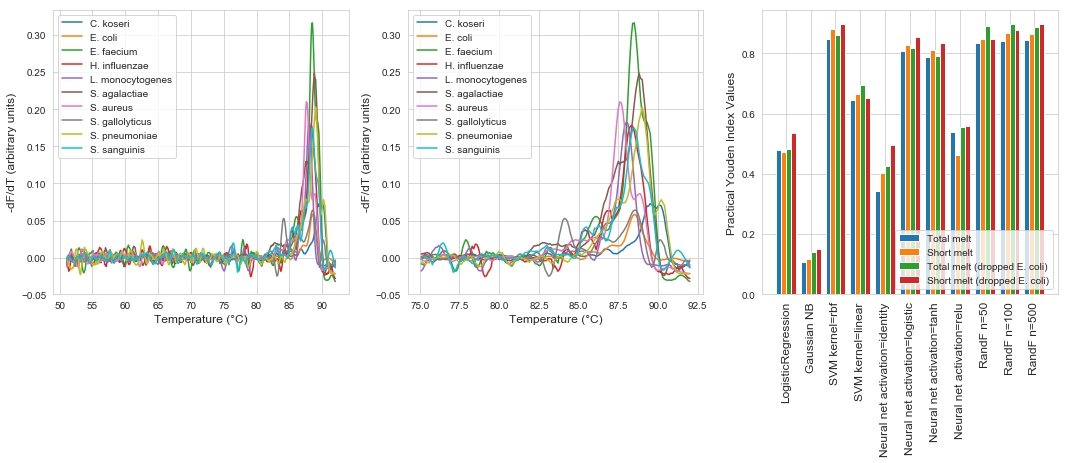

In [ ]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,6.96/1.33))

for label in np.unique(all_dfs.index):
    ax1.plot(all_dfs.columns.map(float),all_dfs.loc[label].iloc[0], label=label)
ax1.set_xlabel('Temperature (°C)', fontsize=12)
ax1.set_ylabel('-dF/dT (arbitrary units)', fontsize=12)
ax1.legend()

for label in np.unique(all_dfs.index):
    ax2.plot(all_dfs.columns.map(float)[240:],all_dfs.loc[label].iloc[0,240:], label=label)
ax2.set_xlabel('Temperature (°C)', fontsize=12)
ax2.set_ylabel('-dF/dT (arbitrary units)', fontsize=12)
ax2.legend()

toplot = [0,1,3,4,5,6,7,8,9,10,11]
for i,j in enumerate(toplot):
    ax3.bar(i-.3,compare_all_ecoli[0].iloc[j][2],color='C0', width=0.2, label='Total melt' if i==0 else '')
    ax3.bar(i-.1,compare_all_ecoli[0].iloc[j][3],color='C1', width=0.2, label='Short melt' if i==0 else '')
    ax3.bar(i+.1,compare_all_ecoli[1].iloc[j][2],color='C2', width=0.2, label='Total melt (dropped E. coli)' if i==0 else '')
    ax3.bar(i+.3,compare_all_ecoli[1].iloc[j][3],color='C3', width=0.2, label='Short melt (dropped E. coli)' if i==0 else '')
ax3.set_ylabel('Practical Youden Index Values', fontsize=12)    
ax3.set_xticks(np.arange(len(toplot)))
ax3.set_xticklabels(compare_all_ecoli[0].drop('Gaussian NB, calibrated').index.values, rotation='vertical', fontsize=12)

ax3.legend(loc='lower right')

plt.show()
    


In [ ]:
for label in np.unique(all_dfs.index):
    print(label)

C. koseri
E. coli
E. faecium
H. influenzae
L. monocytogenes
S. agalactiae
S. aureus
S. gallolyticus
S. pneumoniae
S. sanguinis


# Plotting Functions

In [ ]:
# ax = plt.gca()
# handles, labels = ax.get_legend_handles_labels()
# handles[-1] = mlines.Line2D([], [], color='k', marker='+', mew=2, ms=20)
# plt.legend(handles,labels,bbox_to_anchor=(1.05, 1), loc='upper left')

In [35]:
def plot_boxplot_simple_data(fpr, tpr, thresholds, acc_thresh, option=0):
     # Calculate youden
    youden_index = tpr - fpr 
    fpr_thresh = fpr[np.argmax(youden_index)]
    tpr_thresh = tpr[np.argmax(youden_index)]
    
    #  Find threshold near accumulated_threshold
    idx = find_nearest(thresholds, acc_thresh)
    
    if (option==0):
        return [tpr_thresh-fpr_thresh, tpr[idx]-fpr[idx]]
    else:
        return [1-fpr_thresh, tpr_thresh, tpr_thresh-fpr_thresh, 1-fpr[idx], tpr[idx], tpr[idx]-fpr[idx]]


In [ ]:
ax1.get_xlabel()

''

In [96]:
def plot_boxplot_simple(index,score, fpr, tpr, thresholds, roc_auc, threshold, acc_thresh, title):
    
    # Define color palette
    clrs = ['C0' if (x < 10) else 'C1' for x in range(60)]
#     clrs = ['C0' if (x < 9) else 'C1' for x in range(59)] # dropping E. coli

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6.96/1.33), gridspec_kw={'width_ratios': [2.5, 1]})
    
    # Plot boxplot on ax1
    sns.boxplot(x=index, y=score, dodge=False, showfliers=False, palette=clrs, ax=ax1)
    ax1.set_ylabel('Probability', fontsize=12)
    
    
    plt.sca(ax1)
    plt.xticks((np.arange(60)), rotation='vertical')
#     plt.xticks((np.arange(59)), rotation='vertical') # dropping E. coli

    # Set short x labels
    ax1.set_xticklabels([t.get_text() for t in ax1.get_xticklabels()][:10]+short_labels)
    
    # Plot ROC curve on ax2
    ax2.plot(fpr, tpr, label='Synthetic melts (area = %0.2f)' %(roc_auc))
    ax2.plot([0, 1], [0, 1], color='black', linestyle='--')
    ax2.set_xlim([-0.05, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('False Positive Rate', fontsize=12)
    ax2.set_ylabel('True Positive Rate', fontsize=12)
    
    # Calculate youden
    youden_index = tpr - fpr 
    fpr_thresh = fpr[np.argmax(youden_index)]
    tpr_thresh = tpr[np.argmax(youden_index)]
    
    #  Find threshold near accumulated_threshold
    idx = find_nearest(thresholds, acc_thresh)
    
    # Plot threshold markers
    ax2.plot(fpr[idx], tpr[idx], 'y+', mew=2, ms=10, label='Practical threshold', color='grey') 
    ax2.plot(fpr_thresh, tpr_thresh, '+', mew=2, ms=10, label='Optimal threshold', color='orange')
    ax2.legend()
    
#     # Plot AUC textbox
#     ax2.text(0.5,0.2, 'AUC = %.3f' %roc_auc, fontsize=14,bbox=dict(facecolor='none', edgecolor='k'))
    
    # Plot horizontal threshold lines
    ax1.hlines(y=acc_thresh, xmin=-1, xmax=66, color='grey', linestyle='dashed', label='Practical Threshold')
    ax1.hlines(y=threshold, xmin=-1, xmax=66, color='orange', linestyle='dashed', label='Optimal Threshold')
    
    # Make legend look good
    blue_patch = mpatches.Patch(color='C0', label='Known')
    orange_patch = mpatches.Patch(color='C1', label='Novel')
    orange_line = mlines.Line2D([], [], color='orange', linestyle='--', label='Optimal threshold')
    grey_line = mlines.Line2D([], [], color='grey', linestyle='--', label='Practical threshold')
    ax1.legend(handles=[blue_patch,orange_patch,grey_line,orange_line])

    # Adjust spacing between subplots
    plt.subplots_adjust(wspace=0.1)
    plt.suptitle(title, fontsize=12, y=0.92, fontweight="bold")
#     plt.legend()
    print(title)
    
    plt.savefig('../../reports/figures/'+title+'.svg', bbox_inches='tight')
    # plt.savefig('../../reports/figures/Figure6.svg', bbox_inches='tight')

    plt.show()
    
    # Save sensitivity/specificity data
    return [threshold, 1-fpr_thresh, tpr_thresh, tpr_thresh-fpr_thresh, acc_thresh, 1-fpr[idx], tpr[idx], tpr[idx]-fpr[idx]]

    
# plot_boxplot_simple(select['index'].values[0], select['score'].values[0], select_roc['fpr'].values[0], select_roc['tpr'].values[0], select_roc['thresholds'].values[0],select_roc['auc'].values[0], select_roc['threshold'].values[0], acc_thresholds[0], 'test')

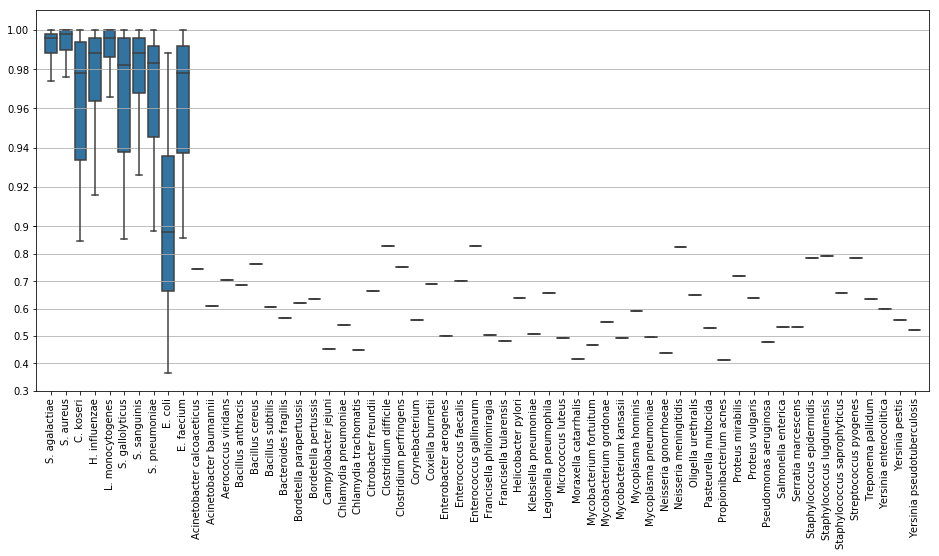

In [ ]:
# linear and log axes for the same plot?
# starting with the histogram example from 
# http://matplotlib.org/mpl_toolkits/axes_grid/users/overview.html
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

def plot_boxplot(index,score):

    plt.figure(figsize=(16,7))

    axMain = plt.subplot(111)
    # axMain.set_yscale('log')
    axMain.set_ylim((0, 0.9))
    sns.boxplot(x=index, y=score, dodge=False, showfliers=False, palette=clrs, ax=axMain)


    divider = make_axes_locatable(axMain)
    axLin = divider.append_axes("top", size=3.0, pad=0, sharex=axMain)
    sns.boxplot(x=index, y=score, dodge=False, showfliers=False, palette=clrs, ax=axLin)
    axLin.set_ylim((0.9, 1.01))

    # Removes bottom axis line
    axLin.spines['bottom'].set_visible(False)
    axMain.spines['top'].set_visible(False)
    axLin.tick_params(axis='x',length=0)
    plt.setp(axLin.get_xticklabels(), visible=False)

    # Remove overlapping 0.90
    yticks = axLin.yaxis.get_major_ticks()
    yticks[0].label1.set_visible(False)

    # Remove 'probability' labels
    axMain.set_ylabel('')
    axLin.set_ylabel('') 

    # Get rid of double ticks
    # yticks = axMain.yaxis.get_major_ticks()
    # [ytick.label1.set_visible(False) for ytick in yticks]

    plt.sca(axMain)
    plt.xticks((np.arange(60)), rotation='vertical')
    plt.xlim(-1,60)
    plt.ylim(0.5,0.9)
    plt.yticks([0.3,0.4,0.5,0.6,0.7,0.8,0.9])

    axMain.grid(True, axis='y')
    axLin.grid(True, axis='y')

    plt.show()
    
    
plot_boxplot(index=select['index'].values[0], score=select['score'].values[0])

# Show that E. Coli is an outlier

# one-sided t-test to show classification score mean E. coli is lower than all others

In [ ]:
save=[]
for k in range(4):
    df_fig_save = pd.read_pickle(save_folder+'uMelt_fig_save'+str(k)+'.pkl')
    
    for method in df_fig_save[df_fig_save['novelty_method']=='prob_all']['method'].values:
        select = df_fig_save[(df_fig_save['novelty_method']=='prob_all') & (df_fig_save['method']==method)]
      
        scores=[]
        for label in np.unique(all_dfs.index):        
            indices = np.where(select['index'].values[0] == label)
            scores.append(select['score'].values[0].values[indices])
            
        pvalues_all=[]  
        pvalues_all_new=[]    
        for i,score in enumerate(scores):
            pvalues=[]
            pvalues_new=[]
            for j,score2 in enumerate(scores):
                t,p = stats.ttest_ind(score, score2, equal_var = False)
                pvalues.append(p)
                if(t>=0 and (p/2)<0.01):
                    pvalues_new.append(True)
                elif(i==j):
                    pvalues_new.append(True)
                else:
                    pvalues_new.append(False)

            pvalues_all.append(pvalues)
            pvalues_all_new.append(pvalues_new) 

            
        pvalues_all = pd.DataFrame(pvalues_all, index=np.unique(all_dfs.index), columns=np.unique(all_dfs.index))
        pvalues_all_new = pd.DataFrame(pvalues_all_new, index=np.unique(all_dfs.index), columns=np.unique(all_dfs.index))    

        
#         save.append([i,method,pd.DataFrame(pvalues_all)])
        save.append([k,method,pd.DataFrame(pvalues_all_new)])

In [ ]:
for i in range(len(save)):
#     subtract_diag = save[i][2]-np.diag(np.diag(save[i][2]))
    for label in np.unique(all_dfs.index):
        if(np.all(save[i][2][label])):
            print(save[i][0],save[i][1],label)

0 LogisticRegression E. coli
0 SVM kernel=linear E. coli
0 Neural net activation=logistic E. coli
0 RandF n=50 E. coli
0 RandF n=100 E. coli
0 RandF n=500 E. coli
1 LogisticRegression E. coli
1 Gaussian NB, calibrated E. coli
1 SVM kernel=rbf E. coli
1 SVM kernel=linear E. coli
1 Neural net activation=identity E. coli
1 Neural net activation=relu E. coli
1 RandF n=50 E. coli
1 RandF n=100 E. coli
1 RandF n=500 E. coli
2 LogisticRegression E. coli
2 SVM kernel=linear E. coli
2 Neural net activation=logistic E. coli
2 RandF n=50 E. coli
2 RandF n=100 E. coli
2 RandF n=500 E. coli
3 LogisticRegression E. coli
3 Gaussian NB, calibrated E. coli
3 SVM kernel=rbf E. coli
3 SVM kernel=linear E. coli
3 Neural net activation=identity E. coli
3 Neural net activation=relu E. coli
3 RandF n=50 E. coli
3 RandF n=100 E. coli
3 RandF n=500 E. coli


# Other efforts

In [ ]:
all_dfs = pd.read_csv('//172.16.236.148/meltanalysis2/Lennart/Publications/2. Probabilistic novelty detection/Data/all_dfs.csv', index_col=0)

In [ ]:
for label in np.unique(all_dfs.index):
    print(label, len(all_dfs.loc[label]))

C. koseri 2052
E. coli 843
E. faecium 1137
H. influenzae 2265
L. monocytogenes 2244
S. agalactiae 2249
S. aureus 2028
S. gallolyticus 2006
S. pneumoniae 1255
S. sanguinis 2202


In [ ]:
for label in np.unique(all_dfs.index):
    print(label, all_dfs.loc[label].std(axis=0).mean())

C. koseri 0.006155888166665541
E. coli 0.005006802959502251
E. faecium 0.00834509367091085
H. influenzae 0.007309336982823117
L. monocytogenes 0.005048818536639568
S. agalactiae 0.007774917229373095
S. aureus 0.005944915510618882
S. gallolyticus 0.00547093602117605
S. pneumoniae 0.007993689112367891
S. sanguinis 0.006980760190480355


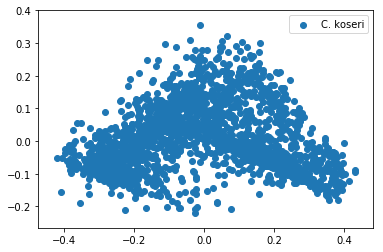

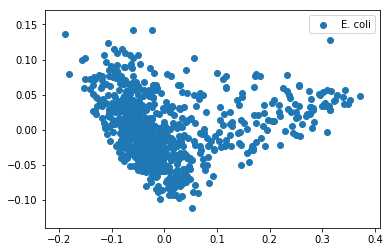

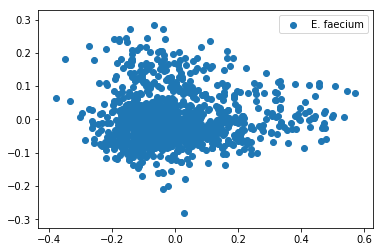

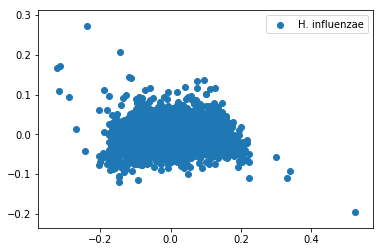

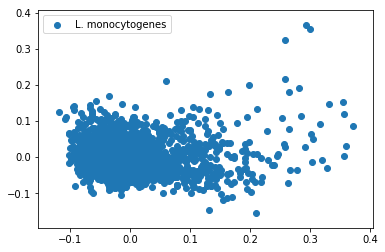

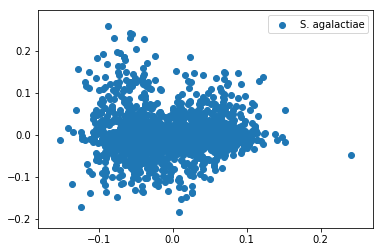

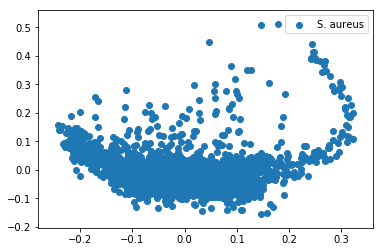

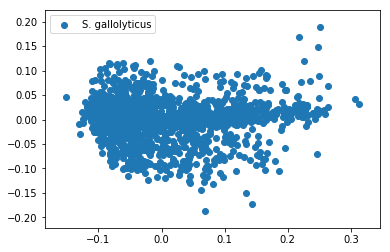

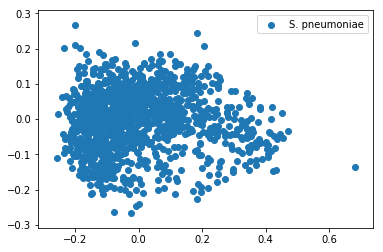

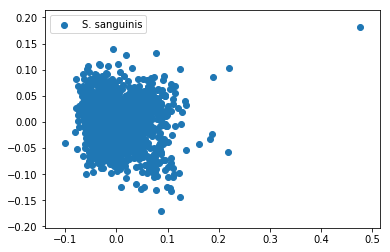

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

for label in np.unique(all_dfs.index):
    X = pca.fit_transform(all_dfs.loc[label])
    plt.scatter(X[:,0], X[:,1], label=label)
    plt.legend()
    plt.show()